# Urban Heat Island (UHI) Analysis -  Team 5
### Hult International Business School
### Business Challenge III
#### April 25th, 2025

Team 5. Rafael Martínez, Sarah Koopman, Federico Zaninelli, Nehal Jain & Ritu Pomaje

## Introduction

In this project, we developed a machine learning model using Sentinel-2 satellite imagery to predict Urban Heat Island (UHI) intensities in Montgomery County, Maryland, and assessed its generalizability to Manhattan, New York City. By leveraging 11 spectral bands and performing extensive feature engineering—including vegetation indices, moisture content, urban density, and spatial factors such as proximity to parks, water bodies, and roads—we aimed to capture the complex interactions driving urban heat patterns.

To comprehensively represent the region, we strategically defined multiple bounding boxes, each covering roughly 82 km², which collectively captured approximately 95% of the available data. Employing a Random Forest Regressor, our final model achieved strong predictive performance on training data (R² = 0.989) while exhibiting moderate generalization (test R² = 0.618), highlighting both its effectiveness and the complexity of spatial extrapolation.

Ultimately, our work provides an interpretable, scalable framework that informs targeted urban planning interventions aimed at mitigating urban heat, promoting sustainability, and enhancing climate resilience.

## Actionable Recommendations

Based on our UHI prediction model analysis, basis the limitations and features, we propose three key recommendations for effectively mitigating urban heat islands.

**1. Green Spaces**

We found that NDTI feature was a strong predictor in identifying low-vegetation, high-heat areas. This means that increasing vegetation is key. We recommend supporting policies around implementation of green roofs, vertical gardens, and the development of more urban parks, particularly in heat-vulnerable zones identified through our model. We can draw inspiration from - Singapore leads globally with its ‘City in a Garden’ strategy, integrating nature across urban landscapes with sky gardens and park connectors (Global Business Outlook, 2023). This significantly cools the environment while enhancing the living standards.

**2. Reimagining Roads**

Our model further placed importance on the feature distance to roads, which hints that the more roads, and asphalt heavy surface, the more concentrated heat storages in a city. Traditional black asphalt absorbs an enormous amount of solar radiation during the day and gives it out gradually at night—completely adding to the Urban Heat Island effect. To combat this, one promising answer is to switch to cool pavements, materials that reflect more sunlight and absorb less heat. For example, in Los Angeles, a city facing extreme summer heat, launched a pilot program that used a product called CoolSeal - a light-gray, shiny, liquid treatment sprayed directly on common pavement (Los Angeles Times, 2023). This coating cools surface temperatures up to 10 degrees Fahrenheit, which sounds like nothing, yet on a citywide basis, it can cool ambient temperatures, reduce the need for air conditioning, and even save lives during heat waves. 

**3. Pollution Prevention**

Our model identified BO1, a key Sentinel-2 band that is related to aerosol and pollution levels which helped us identify that that pollution acts as a heat trap, which adds to the UHI effect.Pollution absorbs and re-emits heat, especially in congested traffic zones, which enhances the Urban Heat Island effect. Stricter pollution monitoring, using sensors and satellite observation to track emissions in real-time, is recommended. Cities could also implement emission-reducing measures like low-emission zones and congestion pricing. A good case in point is Stockholm, which enforces strict low-emission zones and has an ongoing air quality monitoring system (IEEP, 2024). These efforts have shown positive impacts on public health and measurable decrease in the city's heat load.

### Loading Dependencies

To run this notebook, we run the following packages imported below installed.

In [11]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# System utilities
import os
from tqdm import tqdm

# Data Science basics
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data
import rioxarray as rxr
import rasterio
from rasterio import windows, features, warp
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds

# Geospatial vector data
import geopandas as gpd
import fiona
from shapely.geometry import Point
from shapely.ops import unary_union
from geopandas.tools import sjoin_nearest
import osmnx as ox

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Image processing
from PIL import Image

# Feature engineering & machine learning
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.datasets import make_regression

from scipy.stats import uniform, randint, loguniform
from xgboost import XGBRegressor

# Planetary Computer tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo
import stackstac
from odc.stac import stac_load

## Analysis and Code

### Extracting Data from Sentinel 2

To ensure comprehensive geographic and environmental coverage, we divided Montgomery County, Maryland, into a grid of overlapping bounding boxes (see image below). Each box was selected to capture distinct variations in land cover—urban centers, suburban sprawl, vegetated zones, and water-adjacent areas, while balancing spatial granularity and data completeness. We collected the data from 1 - july -2022 to 1 Sep - 2022, as our earlier analysis showed this was a period with the lowest cloud coverage, wind speeds and rainfall. Our optimal bounding box size is 82 sqm.

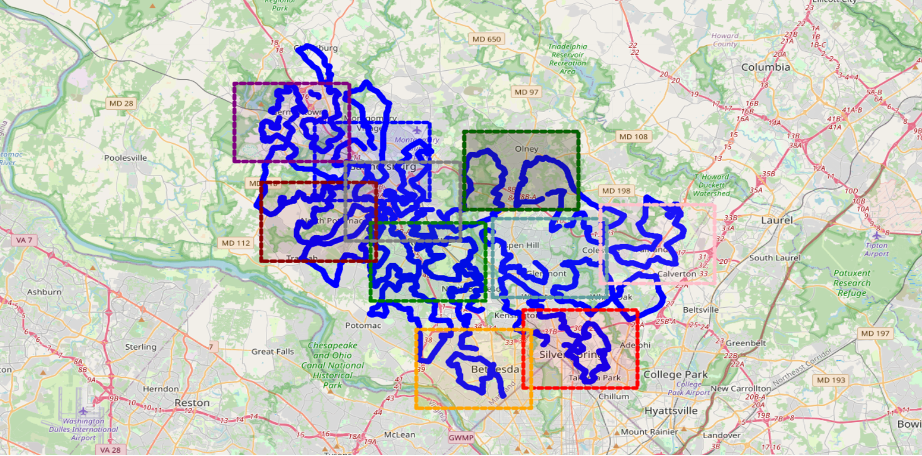

This tiling strategy allowed us to build a scalable modeling approach. It helped us handle the Sentinel-2 data more efficiently by isolating regions of interest and minimizing cloud interference. From each bounding box, we computed mean and standard deviation values of Sentinel-2 bands (B01 to B12). These aggregated statistics gave us a more normalized result, whilst allowing us to see the variance in each data point.

It should be noted that we initially took a tile approach and tried to take a Tiff image, this meant we took centroids in the train csv area which had a circular bounding box, with a radius of 2.125. However, this approach did not lead to good training data, most likely due to unclear (i.e., high cloud coverage) images.

In [6]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
lower_left  = (39.0397, -77.0967)
upper_right = (39.0997, -76.9967)

# Calculate the bounds for doing an archive data search
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

# Define the time window
time_window = "2022-07-01/2022-09-01"

In [7]:
# calling the API to get the data
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)

# understanding how many scenes we have per time period
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 12


In [8]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

# Define the pixel resolution and the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

In [9]:
# getting all the bands data 
data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds)

# View the dimensions of our XARRAY and the loaded variables
# This insures we have the right coordinates and spectral bands in our xarray
display(data)

<xarray.Dataset> Size: 148MB
Dimensions:      (latitude: 669, longitude: 1114, time: 9)
Coordinates:
  * latitude     (latitude) float64 5kB 39.1 39.1 39.1 ... 39.04 39.04 39.04
  * longitude    (longitude) float64 9kB -77.1 -77.1 -77.1 ... -77.0 -77.0 -77.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 72B 2022-07-04T15:48:19.024000 ... 202...
Data variables:
    B01          (time, latitude, longitude) uint16 13MB dask.array<chunksize=(1, 669, 1114), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 13MB dask.array<chunksize=(1, 669, 1114), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 13MB dask.array<chunksize=(1, 669, 1114), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 13MB dask.array<chunksize=(1, 669, 1114), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 13MB dask.array<chunksize=(1, 669, 1114), meta=np.ndarray>
    B06          (time, latitude, longitude) uint16 13MB dask.array<chunksize=(1, 669, 1114), meta=np.ndarray>
    B07          (time, latitude, longitude) uint16 13MB dask.array<chunksize=(1, 669, 1114), meta=np.ndarray>
    B08          (time, latitude, longitude) uint16 13MB dask.array<chunksize=(1, 669, 1114), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 13MB dask.array<chunksize=(1, 669, 1114), meta=np.ndarray>
    B11          (time, latitude, longitude) uint16 13MB dask.array<chunksize=(1, 669, 1114), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 13MB dask.array<chunksize=(1, 669, 1114), meta=np.ndarray>

In [14]:
# Plot sample images from the time series
plot_data = data[["B04","B03","B02"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=2500)
plt.show()

### Save the output data in a GeoTIFF file
After checking the images we select them individually and save them to a tiff file. Each image is labeled by it's bounding box and time window. 

In [ ]:
# Setting a file name
filename = "small_box8_1.tiff"

# We will pick a single time slice from the time series (e.g., time=7) 
data_slice = data.isel(time=1)

# Calculate the dimensions of the file
# height = median.dims["latitude"]
# width = median.dims["longitude"]
height = data_slice.dims["latitude"]
width = data_slice.dims["longitude"]

# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data_slice.rio.write_crs("epsg:4326", inplace=True)
data_slice.rio.write_transform(transform=gt, inplace=True);

# Create the GeoTIFF output file using the defined parameters 
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=12,compress='lzw',dtype='float64') as dst:
    dst.write(data_slice.B01,1)
    dst.write(data_slice.B02,2)
    dst.write(data_slice.B03,3) 
    dst.write(data_slice.B04,4)
    dst.write(data_slice.B05,5)
    dst.write(data_slice.B06,6)
    dst.write(data_slice.B07,7) 
    dst.write(data_slice.B08,8)
    dst.write(data_slice.B8A,9) 
    dst.write(data_slice.B11,10) 
    dst.write(data_slice.B12,11)
    dst.close()

### Response Variable

Before building the model, we need to load in the Urban Heat Island (UHI) index training dataset. The training data has the longitude and latitude coordinate for each point as well as the UHI index.

In [8]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("./Training_Data_Hult_Maryland copy.csv")
ground_df.head()

Longitude   Latitude  UHI Index
0 -77.302700  39.109905   0.993571
1 -77.302690  39.109855   0.994674
2 -77.302677  39.109960   0.993571
3 -77.302655  39.109808   0.994674
4 -77.302630  39.110017   0.993571

### Predictor Variables


In [1]:
"""
Defining a UDF to:
1. Read the data from the TIFF images
2. Claculate the mean and std of each longitude and latitude point
3. Stack the data
4. Fill in the data for points which are not in TIFF images by it's nearest‑neighbor
"""

def map_satellite_data_with_fill(tiff_paths, csv_path):
    # 1) read your points
    df_pts = pd.read_csv(csv_path)
    coords = df_pts[['Latitude','Longitude']].to_numpy()
    lats, lons = coords[:,0], coords[:,1]

    band_names = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B11','B12']
    dfs = []

    # 2) build per‑tiff DataFrames with NaNs for OOB
    for tiff in tiff_paths:
        data = rxr.open_rasterio(tiff)
        xmin, ymin, xmax, ymax = data.rio.bounds()
        transformer = Transformer.from_crs("EPSG:4326", data.rio.crs, always_xy=True)

        cols = {b: [] for b in band_names}
        for lat, lon in tqdm(zip(lats, lons), total=len(lats), desc=f"Mapping {tiff}"):
            x, y = transformer.transform(lon, lat)
            # OOB check → nan
            if not (xmin <= x <= xmax and ymin <= y <= ymax):
                for b in band_names:
                    cols[b].append(np.nan)
                continue

            # in‑bounds → nearest
            for i, b in enumerate(band_names, start=1):
                cols[b].append(
                    data.sel(x=x, y=y, band=i, method="nearest")
                        .values.item()
                )

        dfs.append(pd.DataFrame(cols, index=df_pts.index))

    # 3) stack and nan‑aware stats
    summary = df_pts[['Latitude','Longitude']].copy()
    stacked = {}
    for b in band_names:
        arr = np.stack([df[b].values for df in dfs], axis=1)  # (n_pts, N_tiffs)
        summary[f"{b}_mean"]  = np.nanmean(arr, axis=1)
        summary[f"{b}_std"]   = np.nanstd(arr, axis=1)
        summary[f"{b}_count"] = np.sum(~np.isnan(arr), axis=1)
        stacked[b] = arr

    # 4) fill points with count==0 by nearest‑neighbor in lat/lon space
    no_data = summary['B01_count']==0
    if no_data.any():
        # build neighbors only among points with data
        has_data = ~no_data
        nbrs = NearestNeighbors(n_neighbors=1).fit(coords[has_data])
        dists, idxs = nbrs.kneighbors(coords[no_data])
        # for each band, copy mean/std from nearest valid point
        for b in band_names:
            mean_col = f"{b}_mean"
            std_col  = f"{b}_std"
            # indices of the valid rows and the no_data rows
            valid_indices = np.where(has_data)[0]
            for target_idx, neigh_idx in zip(np.where(no_data)[0], idxs.flatten()):
                source_idx = valid_indices[neigh_idx]
                summary.at[target_idx, mean_col] = summary.at[source_idx, mean_col]
                summary.at[target_idx, std_col]  = summary.at[source_idx, std_col]

    return summary


In [155]:
# Uploading the GeoTIFF Images and transforming data to CSV

if __name__ == "__main__":
    # 1) Uploading TIFF files path:
    tiff_paths = [
        "./TIFF MONT_80SQM/SMALL_time4_.tiff",  
        "./TIFF MONT_80SQM/SMALL_time3_.tiff",   
        "./TIFF MONT_80SQM/SMALL_time2_.tiff",   
        "./TIFF MONT_80SQM/SMALL_time1_.tiff",   
        "./TIFF MONT_80SQM/SMALL_time0_.tiff",  
        "./TIFF MONT_80SQM/small_box2_0.tiff",   
        "./TIFF MONT_80SQM/small_box2_1.tiff",   
        "./TIFF MONT_80SQM/small_box2_6.tiff",   
        "./TIFF MONT_80SQM/small_box2_9.tiff",   
        "./TIFF MONT_80SQM/small_box2_10.tiff", 
        "./TIFF MONT_80SQM/box3_time0_.tiff",   
        "./TIFF MONT_80SQM/box3_time4_.tiff",   
        "./TIFF MONT_80SQM/box3_time6_.tiff",  
        "./TIFF MONT_80SQM/box3_time9_.tiff",   
        "./TIFF MONT_80SQM/box3_time10_.tiff",
        "./TIFF MONT_80SQM/box5_time0_.tiff",   
        "./TIFF MONT_80SQM/box5_time1_.tiff",   
        "./TIFF MONT_80SQM/box5_time4_.tiff",   
        "./TIFF MONT_80SQM/box5_time5_.tiff",   
        "./TIFF MONT_80SQM/box5_time7_.tiff",
        "./TIFF MONT_80SQM/box6_time0_.tiff",   
        "./TIFF MONT_80SQM/box6_time5_.tiff",   
        "./TIFF MONT_80SQM/box6_time6_.tiff",   
        "./TIFF MONT_80SQM/box6_time9_.tiff",   
        "./TIFF MONT_80SQM/box6_time10_.tiff",
        "./TIFF MONT_80SQM/box7_time0_.tiff",   
        "./TIFF MONT_80SQM/box7_time4_.tiff",   
        "./TIFF MONT_80SQM/box7_time6_.tiff",   
        "./TIFF MONT_80SQM/box7_time9_.tiff",   
        "./TIFF MONT_80SQM/box7_time10_.tiff",
        "./TIFF MONT_80SQM/box8_time0_.tiff",   
        "./TIFF MONT_80SQM/box8_time1_.tiff",   
        "./TIFF MONT_80SQM/box8_time4_.tiff",   
        "./TIFF MONT_80SQM/box8_time5_.tiff",   
        "./TIFF MONT_80SQM/box8_time8_.tiff",
        "./TIFF MONT_80SQM/box9_time0_.tiff",   
        "./TIFF MONT_80SQM/box9_time3_.tiff",   
        "./TIFF MONT_80SQM/box9_time4_.tiff",   
        "./TIFF MONT_80SQM/box9_time5_.tiff",   
        "./TIFF MONT_80SQM/box9_time8_.tiff",
        "./TIFF MONT_80SQM/box10_time0_.tiff",   
        "./TIFF MONT_80SQM/box10_time1_.tiff",   
        "./TIFF MONT_80SQM/box10_time5_.tiff",   
        "./TIFF MONT_80SQM/box10_time7_.tiff",   
        "./TIFF MONT_80SQM/box10_time8_.tiff",
        "./TIFF MONT_80SQM/box11_time0_.tiff",   
        "./TIFF MONT_80SQM/box11_time4_.tiff",   
        "./TIFF MONT_80SQM/box11_time6_.tiff",   
        "./TIFF MONT_80SQM/box11_time9_.tiff",   
        "./TIFF MONT_80SQM/box11_time10_.tiff",
        "./TIFF MONT_80SQM/box12_time0_.tiff",   
        "./TIFF MONT_80SQM/box12_time6_.tiff",   
        "./TIFF MONT_80SQM/box12_time9_.tiff",   
        "./TIFF MONT_80SQM/box12_time10_.tiff",
        "./TIFF MONT_80SQM/box13_time0_.tiff",   
        "./TIFF MONT_80SQM/box13_time1_.tiff",   
        "./TIFF MONT_80SQM/box13_time4_.tiff",   
        "./TIFF MONT_80SQM/box13_time5_.tiff",   
        "./TIFF MONT_80SQM/box13_time8_.tiff"   
    ]

    # 2) Uploading training data:
    csv_path = "./Training_Data_Hult_Maryland copy.csv"

    # 3) Running above defined function:
    result = map_satellite_data_with_fill(tiff_paths, csv_path)

    # 4) Saving and inspecting the data:
    result.to_csv("./59images data_smallbox_train.csv", index=False)

Mapping ./TIFF MONT_80SQM/SMALL_time4_.tiff: 100%|█| 34502/34502 [00:08<00:00, 4
Mapping ./TIFF MONT_80SQM/SMALL_time3_.tiff: 100%|█| 34502/34502 [00:08<00:00, 4
Mapping ./TIFF MONT_80SQM/SMALL_time2_.tiff: 100%|█| 34502/34502 [00:08<00:00, 4
Mapping ./TIFF MONT_80SQM/SMALL_time1_.tiff: 100%|█| 34502/34502 [00:08<00:00, 4
Mapping ./TIFF MONT_80SQM/SMALL_time0_.tiff: 100%|█| 34502/34502 [00:08<00:00, 4
Mapping ./TIFF MONT_80SQM/small_box2_0.tiff: 100%|█| 34502/34502 [00:18<00:00, 1
Mapping ./TIFF MONT_80SQM/small_box2_1.tiff: 100%|█| 34502/34502 [00:18<00:00, 1
Mapping ./TIFF MONT_80SQM/small_box2_6.tiff: 100%|█| 34502/34502 [00:18<00:00, 1
Mapping ./TIFF MONT_80SQM/small_box2_9.tiff: 100%|█| 34502/34502 [00:18<00:00, 1
Mapping ./TIFF MONT_80SQM/small_box2_10.tiff: 100%|█| 34502/34502 [00:18<00:00, 
Mapping ./TIFF MONT_80SQM/box3_time0_.tiff: 100%|█| 34502/34502 [00:14<00:00, 24
Mapping ./TIFF MONT_80SQM/box3_time4_.tiff: 100%|█| 34502/34502 [00:14<00:00, 24
Mapping ./TIFF MONT_80SQM/bo

In [429]:
# Reading the data to csv and checking it
final_data = pd.read_csv("./59images data_smallbox_train.csv")
final_data.head(5)

Latitude  Longitude  B01_mean    B01_std  B01_count  B02_mean    B02_std  \
0  39.109905 -77.302700    1378.8  40.984875          0    1403.2  24.749949   
1  39.109855 -77.302690    1378.8  40.984875          0    1403.2  24.749949   
2  39.109960 -77.302677    1378.8  40.984875          0    1403.2  24.749949   
3  39.109808 -77.302655    1378.8  40.984875          0    1403.2  24.749949   
4  39.110017 -77.302630    1378.8  40.984875          0    1403.2  24.749949   

   B02_count  B03_mean    B03_std  ...  B08_count  B8A_mean     B8A_std  \
0          0    1602.0  38.099869  ...          0    4476.8  119.085515   
1          0    1602.0  38.099869  ...          0    4476.8  119.085515   
2          0    1602.0  38.099869  ...          0    4476.8  119.085515   
3          0    1602.0  38.099869  ...          0    4476.8  119.085515   
4          0    1602.0  38.099869  ...          0    4476.8  119.085515   

   B8A_count  B11_mean    B11_std  B11_count  B12_mean    B12_std  B12_count  
0          0    2815.8  73.936189          0    1952.0  52.687759          0  
1          0    2815.8  73.936189          0    1952.0  52.687759          0  
2          0    2815.8  73.936189          0    1952.0  52.687759          0  
3          0    2815.8  73.936189          0    1952.0  52.687759          0  
4          0    2815.8  73.936189          0    1952.0  52.687759          0  

[5 rows x 35 columns]

In [430]:
#Analysing how many images have B01_count = 0, i.e., are inputted through "nearest neighbour" data
final_data["B01_count"].value_counts()

B01_count
5     20340
10     6335
0      4875
9      1533
4       535
14      473
15      411
Name: count, dtype: int64

## Joining the predictor variables and response variables

In [482]:
# Creating a UDF to joing the two datasets based on their Latitude and Longitude Coordinates
def combine_two_datasets(dataset1, dataset2):
    return dataset1.merge(
        dataset2,
        on=['Latitude', 'Longitude'],
        how='left'
    )

In [483]:
# Combining ground data and final data into a single dataset and checking the data
uhi_data = combine_two_datasets(ground_df,final_data)
uhi_data.head()

uhi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34502 entries, 0 to 34501
Data columns (total 36 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  34502 non-null  float64
 1   Latitude   34502 non-null  float64
 2   UHI Index  34502 non-null  float64
 3   B01_mean   34502 non-null  float64
 4   B01_std    34502 non-null  float64
 5   B01_count  34502 non-null  int64  
 6   B02_mean   34502 non-null  float64
 7   B02_std    34502 non-null  float64
 8   B02_count  34502 non-null  int64  
 9   B03_mean   34502 non-null  float64
 10  B03_std    34502 non-null  float64
 11  B03_count  34502 non-null  int64  
 12  B04_mean   34502 non-null  float64
 13  B04_std    34502 non-null  float64
 14  B04_count  34502 non-null  int64  
 15  B05_mean   34502 non-null  float64
 16  B05_std    34502 non-null  float64
 17  B05_count  34502 non-null  int64  
 18  B06_mean   34502 non-null  float64
 19  B06_std    34502 non-null  float64
 20  B06_co

In [ ]:
# Droping the data which we could not extract bands information on for the training data
uhi_data = uhi_data[uhi_data['B01_count'] > 0].reset_index(drop=True)

# checking the data again and columns
uhi_data.info
uhi_data.columns

In [ ]:
# double checking if all rows are unique
unique_row_count = uhi_data.shape[0] - uhi_data.duplicated().sum()
unique_row_count

### Feature Engineering

Once we had the data, we engineered 13 spectral indices using scientifically validated formulas. These included:

1. **NDVI (Normalized Difference Vegetation Index)**  
   Computed as: (B08 - B04) / (B08 + B04)  
   Bands used: NIR (B08) and Red (B04)  
   Purpose: Measures vegetation density and health. High values indicate dense greenery; low values suggest sparse or no vegetation.


2. **NDWI (Normalized Difference Water Index)**  
   Computed as: (B03 - B08) / (B03 + B08)  
   Bands used: Green (B03) and NIR (B08)  
   Purpose: Detects water content or moisture. High values reflect water bodies; low values indicate dry or urban surfaces.


3. **NDBI (Normalized Difference Built-up Index)**  
   Computed as: (B11 - B08) / (B11 + B08)  
   Bands used: SWIR (B11) and NIR (B08)  
   Purpose: Identifies built-up/urban areas. High values suggest man-made surfaces; low values represent vegetation or water.


4. **GNDVI (Green Normalized Difference Vegetation Index)**  
   Computed as: (B08 - B03) / (B08 + B03)  
   Bands used: NIR (B08) and Green (B03)  
   Purpose: A vegetation index more sensitive to chlorophyll. Used to detect subtle differences in plant health.


5. **ARVI (Atmospherically Resistant Vegetation Index)**  
   Computed as: (B08 - 2 × B04 + B02) / (B08 + 2 × B04 - B02)  
   Bands used: NIR (B08), Red (B04), Blue (B02)  
   Purpose: Improves NDVI by correcting for atmospheric distortions like haze and aerosols.


6. **EVI (Enhanced Vegetation Index)**  
   Computed as: 2.5 × (B08 - B04) / (B08 + 6 × B04 - 7.5 × B02 + 1)  
   Bands used: NIR (B08), Red (B04), Blue (B02)  
   Purpose: Optimized for high-density vegetation; corrects for atmospheric noise and canopy shadow.


7. **NDSI (Normalized Difference Soil Index)**  
   Computed as: (B03 - B11) / (B03 + B11)  
   Bands used: Green (B03) and SWIR (B11)  
   Purpose: Identifies bare soil or sparse vegetation areas; sometimes used for snow detection.


8. **BSI (Bare Soil Index)**  
   Computed as: [(B11 + B04) - (B08 + B02)] / [(B11 + B04) + (B08 + B02)]  
   Bands used: SWIR (B11), Red (B04), NIR (B08), Blue (B02)  
   Purpose: Highlights exposed soil surfaces. High BSI values correlate with heat-prone barren land.


9. **NDTI (Normalized Difference Tillage Index)**  
   Computed as: (B11 - B12) / (B11 + B12)  
   Bands used: SWIR1 (B11) and SWIR2 (B12)  
   Purpose: Detects disturbed or tilled surfaces; often linked with construction or agriculture.


10. **CADI (Coastal Aerosol Difference Index)**  
    Computed as: (B01 - B02) / (B01 + B02)  
    Bands used: Coastal Aerosol (B01) and Blue (B02)  
    Purpose: Sensitive to aerosols and haze; used to assess air quality near coastlines or urban zones.


11. **Haze Index**  
    Computed as: (B02 - B01) / (B02 + B01)  
    Bands used: Blue (B02) and Coastal Aerosol (B01)  
    Purpose: Indicates the presence of haze or smog. High values signal hazy atmospheric conditions.


12. **is_hazy (Binary Classifier)**  
    Computed as: 1 if B01 > 95th percentile, else 0  
    Bands used: Coastal Aerosol (B01)  
    Purpose: Flags locations with extreme aerosol levels as potentially hazy. Useful for heat-trapping identification.


13. **UI (Urban Index)**  
    Computed as: (B11 - (B08 + B04)) / (B11 + (B08 + B04))  
    Bands used: SWIR (B11), NIR (B08), Red (B04)  
    Purpose: Isolates highly urbanized areas from natural surfaces. High values = urban intensity.

In [487]:
# 1) Compute indices on the _mean bands in uhi_data
uhi_data['NDVI']  = (uhi_data['B08_mean'] - uhi_data['B04_mean']) / (
                      uhi_data['B08_mean'] + uhi_data['B04_mean'])

uhi_data['NDWI']  = (uhi_data['B03_mean'] - uhi_data['B08_mean']) / (
                      uhi_data['B03_mean'] + uhi_data['B08_mean'])

uhi_data['NDBI']  = (uhi_data['B11_mean'] - uhi_data['B08_mean']) / (
                      uhi_data['B11_mean'] + uhi_data['B08_mean'])

uhi_data['GNDVI'] = (uhi_data['B08_mean'] - uhi_data['B03_mean']) / (
                      uhi_data['B08_mean'] + uhi_data['B03_mean'])

uhi_data['ARVI']  = (uhi_data['B08_mean'] - 2 * uhi_data['B04_mean'] + uhi_data['B02_mean']) 
                    / 
                    (uhi_data['B08_mean'] + 2 * uhi_data['B04_mean'] - uhi_data['B02_mean'])

uhi_data['EVI']   = 2.5 * (uhi_data['B08_mean'] - uhi_data['B04_mean']) / (
                      uhi_data['B08_mean']
                    + 6 *  uhi_data['B04_mean']
                    - 7.5 * uhi_data['B02_mean']
                    + 1
                   )

uhi_data['NDSI']  = (uhi_data['B03_mean'] - uhi_data['B11_mean']) / (
                      uhi_data['B03_mean'] + uhi_data['B11_mean']
                    )

# Bare Soil Index
num_bsi = (uhi_data['B11_mean'] + uhi_data['B04_mean']) \
          - (uhi_data['B08_mean'] + uhi_data['B02_mean'])
den_bsi = (uhi_data['B11_mean'] + uhi_data['B04_mean']) \
          + (uhi_data['B08_mean'] + uhi_data['B02_mean'])
uhi_data['BSI']  = num_bsi / den_bsi

uhi_data['NDTI'] = (uhi_data['B11_mean'] - uhi_data['B12_mean']) / (
                     uhi_data['B11_mean'] + uhi_data['B12_mean']
                   )

uhi_data['CADI'] = (uhi_data['B01_mean'] - uhi_data['B02_mean']) / (
                     uhi_data['B01_mean'] + uhi_data['B02_mean']
                   )

uhi_data['HazeIndex'] = (uhi_data['B02_mean'] - uhi_data['B01_mean']) / (
                          uhi_data['B02_mean'] + uhi_data['B01_mean']
                        )

uhi_data['is_hazy'] = (
    uhi_data['B01_mean'] > uhi_data['B01_mean'].quantile(0.95)
).astype(int)

# Urban Index (UI)
uhi_data['UI'] = (
    uhi_data['B11_mean']
  - (uhi_data['B08_mean'] + uhi_data['B04_mean'])
) / (
    uhi_data['B11_mean']
  + (uhi_data['B08_mean'] + uhi_data['B04_mean'])
)

# 2) Clean up infinities/NaNs
uhi_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [488]:
# checking the columns in our data
uhi_data.columns

Index(['Longitude', 'Latitude', 'UHI Index', 'B01_mean', 'B01_std',
       'B01_count', 'B02_mean', 'B02_std', 'B02_count', 'B03_mean', 'B03_std',
       'B03_count', 'B04_mean', 'B04_std', 'B04_count', 'B05_mean', 'B05_std',
       'B05_count', 'B06_mean', 'B06_std', 'B06_count', 'B07_mean', 'B07_std',
       'B07_count', 'B08_mean', 'B08_std', 'B08_count', 'B8A_mean', 'B8A_std',
       'B8A_count', 'B11_mean', 'B11_std', 'B11_count', 'B12_mean', 'B12_std',
       'B12_count', 'NDVI', 'NDWI', 'NDBI', 'GNDVI', 'ARVI', 'EVI', 'NDSI',
       'BSI', 'NDTI', 'CADI', 'HazeIndex', 'is_hazy', 'UI'],
      dtype='object')

**Distances Features**

To enhance real-world applicability, we supplemented spectral data with spatial features derived from geolocation data. These included distances to water bodies, parks, and roads which are factors known to influence urban microclimates through evaporation, shade, and pollution patterns.

Proximity to water bodies enhances evaporative cooling and thermal inertia, reducing local surface temperatures by up to 3 °C within 800 m (Du et al., 2019). Lakes and rivers create “urban cooling islands” via high specific heat capacity and evaporation, leading to 1–2 K temperature reductions on average (Zhang et al., 2022). Modeling distance to water captures spatial heterogeneity in these cooling effects, which vary with water‐body morphology (Li et al., 2023).

Green spaces mitigate UHI through shading and evapotranspiration, lowering surface temperatures by 1–5 °C within 200–300 m of park boundaries (García et al., 2020). Parks disrupt heat‐absorbing impervious surfaces and establish cooling corridors, enhancing thermal comfort and air quality (Du et al., 2023). Including distance to parks reflects the inverse relationship between vegetation proximity and land‐surface temperature (Zhang et al., 2021).

Road networks contribute to urban heating via anthropogenic heat emissions and heat-retaining pavements, with roadway surfaces 2–10 K hotter than adjacent areas (Okeke, 2011). Proximity to major roads correlates strongly with elevated land temperatures, making distance to roads a reliable predictor of localized UHI intensity (Smith & Lee, 2024).

This layered feature engineering approach created a rich, interpretable dataset capable of explaining both physical and anthropogenic contributions to urban heat. It was instrumental not only in improving model accuracy but also in generating actionable insights for urban planning and sustainability efforts.

In [489]:
# Creating the Distance to Water Feature 

# ───────────────────────────────────────────────────────────────
# 1) Prepare your UHI points GeoDataFrame
# ───────────────────────────────────────────────────────────────
uhi_gdf = gpd.GeoDataFrame(
    uhi_data,  # your original DataFrame
    geometry=gpd.points_from_xy(
        uhi_data['Longitude'], uhi_data['Latitude']
    ),
    crs="EPSG:4326"
)

# ───────────────────────────────────────────────────────────────
# 2) Load & stack the water‐bodies + flowlines
# ───────────────────────────────────────────────────────────────
water_shp    = "./NHD_H_Maryland_State_Shape/Shape/NHDWaterbody.shp"
flowline_shp = "./NHD_H_Maryland_State_Shape/Shape/NHDFlowline.shp"


water_all = pd.concat([water_bodies, flow_lines], ignore_index=True)
water_all = gpd.GeoDataFrame(water_all, crs=water_bodies.crs)

# ───────────────────────────────────────────────────────────────
# 3) Reproject to a meter‐based CRS for accurate distances
# ───────────────────────────────────────────────────────────────
proj_crs    = "EPSG:26918"
uhi_proj    = uhi_gdf.to_crs(proj_crs)
water_proj  = water_all.to_crs(proj_crs)

# ───────────────────────────────────────────────────────────────
# 4) Nearest‐feature join, pulling in the distance
# ───────────────────────────────────────────────────────────────
joined = sjoin_nearest(
    uhi_proj,
    water_proj[['geometry']],
    how='left',
    distance_col='distance_to_water_body'
)

# ───────────────────────────────────────────────────────────────
# 5) De‐duplicate so each original index appears only once
# ───────────────────────────────────────────────────────────────
# Keep the first occurrence if there were exact ties
joined = joined[~joined.index.duplicated(keep='first')]

# ───────────────────────────────────────────────────────────────
# 6) Assign back into original DataFrame
# ───────────────────────────────────────────────────────────────
uhi_data['distance_to_water_body'] = joined['distance_to_water_body']



In [490]:
# Creating the distance to Park Feature 

# ───────────────────────────────────────────────────────────────
# 1) Prepare your UHI points GeoDataFrame
# ───────────────────────────────────────────────────────────────
uhi_gdf = gpd.GeoDataFrame(
    uhi_data,
    geometry=gpd.points_from_xy(
        uhi_data['Longitude'],
        uhi_data['Latitude']
    ),
    crs="EPSG:4326"
)

# ───────────────────────────────────────────────────────────────
# 2) Inspect & load the PADUS “combined” parks layer
# ───────────────────────────────────────────────────────────────
gdb_path = "./PADUS4_1_State_MD_GDB_KMZ/PADUS4_1_StateMD.gdb"  # ← update this to your actual folder

# confirm the exact layer name
print(fiona.listlayers(gdb_path))
# ► you should see:
#    ['PADUS4_1Fee_State_MD', 'PADUS4_1Easement_State_MD', 
#     'PADUS4_1Proclamation_State_MD',
#     'PADUS4_1Comb_DOD_Trib_NGP_Fee_Desig_Ease_State_MD', …]

combined_layer = "PADUS4_1Comb_DOD_Trib_NGP_Fee_Desig_Ease_State_MD"

parks = gpd.read_file(
    gdb_path,
    layer=combined_layer
)
# now `parks` holds all public lands/parks in one GeoDataFrame

# ───────────────────────────────────────────────────────────────
# 3) Reproject both datasets to a meter CRS for true ground distance
# ───────────────────────────────────────────────────────────────
proj_crs   = "EPSG:26918"   # NAD83 / UTM zone 18N
uhi_proj   = uhi_gdf.to_crs(proj_crs)
parks_proj = parks.to_crs(proj_crs)

# ───────────────────────────────────────────────────────────────
# 4) Nearest‐feature join to compute distance_to_park (in meters)
# ───────────────────────────────────────────────────────────────
joined = sjoin_nearest(
    uhi_proj,
    parks_proj[['geometry']],
    how='left',
    distance_col='distance_to_park'
)

# ───────────────────────────────────────────────────────────────
# 5) Drop any exact‐distance ties so each UHI point appears only once
# ───────────────────────────────────────────────────────────────
joined = joined[~joined.index.duplicated(keep='first')]

# ───────────────────────────────────────────────────────────────
# 6) Assign the new feature back into original DataFrame
# ───────────────────────────────────────────────────────────────
uhi_data['distance_to_park'] = joined['distance_to_park']

['PADUS4_1Fee_State_MD', 'PADUS4_1Easement_State_MD', 'PADUS4_1Proclamation_State_MD', 'PADUS4_1Comb_DOD_Trib_NGP_Fee_Desig_Ease_State_MD', 'PADUS4_1Designation_State_MD', 'PADUS4_1Marine', 'Public_Access', 'Agency_Name', 'Agency_Type', 'Category', 'Designation_Type', 'GAP_Status', 'IUCN_Category', 'State_Name']


In [491]:
# Creating the Distance to Roads Feature 

# ───────────────────────────────────────────────────────────────
# 0) Prep your UHI GeoDataFrame (projected)
# ───────────────────────────────────────────────────────────────
proj_crs = "EPSG:26918"  # UTM zone 18N for Maryland
uhi_gdf = gpd.GeoDataFrame(
    uhi_data,
    geometry=gpd.points_from_xy(uhi_data.Longitude, uhi_data.Latitude),
    crs="EPSG:4326"
).to_crs(proj_crs)

# ───────────────────────────────────────────────────────────────
# 1) Geocode Montgomery County → get its boundary Polygon
# ───────────────────────────────────────────────────────────────
county_gdf = ox.geocoder.geocode_to_gdf("Montgomery County, Maryland, USA")
# union_all is gone, so we do:
county_polygon = unary_union(county_gdf.geometry)

# ───────────────────────────────────────────────────────────────
# 2) Build the drivable‐road network from that Polygon
# ───────────────────────────────────────────────────────────────
G = ox.graph_from_polygon(county_polygon, network_type="drive")
roads_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)

# ensure the roads are in our projected CRS
roads_gdf = roads_gdf.set_crs("EPSG:4326", allow_override=True).to_crs(proj_crs)

# ───────────────────────────────────────────────────────────────
# 3) Compute distance_to_major_road via nearest‐join
# ───────────────────────────────────────────────────────────────
joined = sjoin_nearest(
    uhi_gdf,
    roads_gdf[['geometry']],
    how='left',
    distance_col='distance_to_major_road'
)

# drop any ties so each original index appears exactly once
joined = joined[~joined.index.duplicated(keep='first')]

# write it back into your DataFrame
uhi_data['distance_to_major_road'] = joined['distance_to_major_road']

## Model Building

In [492]:
# checking final columns and data
uhi_data.columns

uhi_data.head(n=5)

Index(['Longitude', 'Latitude', 'UHI Index', 'B01_mean', 'B01_std',
       'B01_count', 'B02_mean', 'B02_std', 'B02_count', 'B03_mean', 'B03_std',
       'B03_count', 'B04_mean', 'B04_std', 'B04_count', 'B05_mean', 'B05_std',
       'B05_count', 'B06_mean', 'B06_std', 'B06_count', 'B07_mean', 'B07_std',
       'B07_count', 'B08_mean', 'B08_std', 'B08_count', 'B8A_mean', 'B8A_std',
       'B8A_count', 'B11_mean', 'B11_std', 'B11_count', 'B12_mean', 'B12_std',
       'B12_count', 'NDVI', 'NDWI', 'NDBI', 'GNDVI', 'ARVI', 'EVI', 'NDSI',
       'BSI', 'NDTI', 'CADI', 'HazeIndex', 'is_hazy', 'UI',
       'distance_to_water_body', 'distance_to_park', 'distance_to_major_road'],
      dtype='object')

In [494]:
# Retaining only the columns for B02, B03, NDVI, and UHI Index in the dataset.
uhi_data = uhi_data[['UHI Index', 'B01_mean', 'B01_std',
       'B01_count', 'B02_mean', 'B02_std', 'B03_mean', 'B03_std',
        'B04_mean', 'B04_std', 'B05_mean', 'B05_std',
        'B06_mean', 'B06_std', 'B07_mean', 'B07_std',
       'B08_mean', 'B08_std', 'B8A_mean', 'B8A_std',
       'B11_mean', 'B11_std', 'B12_mean', 'B12_std',
     'NDVI', 'NDWI', 'NDBI', 'GNDVI', 'ARVI', 'EVI', 'NDSI',
       'BSI', 'NDTI', 'CADI', 'HazeIndex', 'UI',
       'distance_to_water_body', 'distance_to_park', 'distance_to_major_road']]

# Also only retaining it in an array
uhi_data_X =  [ 'B01_mean', 'B01_std',
       'B01_count', 'B02_mean', 'B02_std', 'B03_mean', 'B03_std',
        'B04_mean', 'B04_std', 'B05_mean', 'B05_std',
        'B06_mean', 'B06_std', 'B07_mean', 'B07_std',
       'B08_mean', 'B08_std', 'B8A_mean', 'B8A_std',
       'B11_mean', 'B11_std', 'B12_mean', 'B12_std',
     'NDVI', 'NDWI', 'NDBI', 'GNDVI', 'ARVI', 'EVI', 'NDSI',
       'BSI', 'NDTI', 'CADI', 'HazeIndex', 'UI',
       'distance_to_water_body', 'distance_to_park', 'distance_to_major_road']

uhi_data_X

### Train and Test Split 

After experimenting, we decided for a train/test split of 80/20.

In [496]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data ['UHI Index'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123)

### Feature Scaling 

Although feature scaling is a common preprocessing step in machine learning, used particularly for models sensitive to the scale of input features, we did not apply standard scaling in our pipeline. This is because our final model is a Random Forest Regressor, which is a tree-based algorithm. 

Tree-based models split data based on feature thresholds and are inherently insensitive to the magnitude or distribution of the input values. As a result, applying standard scaling (such as StandardScaler or MinMaxScaler) would have no impact on model performance, and was therefore intentionally omitted to keep preprocessing minimal and interpretable.

### Model Training

In [559]:
model = RandomForestRegressor(
    n_estimators=901,
    max_depth=40,
    max_features='sqrt',
    min_samples_split=7,
    bootstrap=False,
    max_samples=None,
    random_state=42
)

# then fit as usual:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=40, max_features='sqrt',
                      min_samples_split=7, n_estimators=901, random_state=42)

In [497]:
# Hyperparameter Tuning our Model - we comment out this section to reduce run time of the notebook

# # 1. Pipeline
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('rf', RandomForestRegressor(
#         random_state=708,
#         oob_score=False,   # set True if you want OOB estimates
#         n_jobs=-1
#     ))
# ])

# # 2. Expanded hyperparameter space
# param_distributions = {
#     'rf__n_estimators':     randint(200, 1001),       # 200 to 1000 trees
#     'rf__max_depth':        randint(5, 51),           # depths from 5 to 50
#     'rf__min_samples_split':randint(2, 11),           # 2 to 10
#     'rf__max_features':     ['sqrt', 'log2', 'auto'],
#     'rf__bootstrap':        [True, False],
#     # if bootstrap=True, you can also sample a fraction of rows:
#     'rf__max_samples':      [None, 0.6, 0.8, 1.0]
# }

# # 3. Scoring
# scorer = make_scorer(mean_squared_error, greater_is_better=False)

# # 4. Randomized search: more iterations & folds
# tuned_rf = RandomizedSearchCV(
#     estimator=pipeline,
#     param_distributions=param_distributions,
#     n_iter=120,      # bump up from 50
#     cv=5,            # 5-fold CV
#     scoring=scorer,
#     random_state=702,
#     n_jobs=-1,
#     verbose=2
# )

# # 5. Fit & inspect
# tuned_rf.fit(X_train, y_train)

# print("Best Hyperparameters Found:")
# for k, v in tuned_rf.best_params_.items():
#     print(f"  {k}: {v}")

Fitting 5 folds for each of 120 candidates, totalling 600 fits


python(15489) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15490) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15491) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15492) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15493) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15494) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15495) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15496) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15497) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END rf__bootstrap=False, rf__max_depth=36, rf__max_features=auto, rf__max_samples=None, rf__min_samples_split=7, rf__n_estimators=281; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=47, rf__max_features=sqrt, rf__max_samples=0.8, rf__min_samples_split=9, rf__n_estimators=388; total time=  36.1s
[CV] END rf__bootstrap=True, rf__max_depth=35, rf__max_features=log2, rf__max_samples=None, rf__min_samples_split=2, rf__n_estimators=293; total time=  30.5s


Exception ignored in: <function ResourceTracker.__del__ at 0x1074adee0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15498) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END rf__bootstrap=False, rf__max_depth=23, rf__max_features=auto, rf__max_samples=0.8, rf__min_samples_split=4, rf__n_estimators=789; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=8, rf__max_features=auto, rf__max_samples=0.6, rf__min_samples_split=5, rf__n_estimators=603; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=48, rf__max_features=sqrt, rf__max_samples=0.6, rf__min_samples_split=8, rf__n_estimators=826; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=48, rf__max_features=sqrt, rf__max_samples=0.6, rf__min_samples_split=8, rf__n_estimators=826; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=43, rf__max_features=log2, rf__max_samples=0.6, rf__min_samples_split=2, rf__n_estimators=229; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=10, rf__max_features=auto, rf__max_samples=None, rf__min_samples_split=4, rf__n_estimators=455; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=10, rf__max

Exception ignored in: <function ResourceTracker.__del__ at 0x107005ee0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15499) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Exception ignored in: <function ResourceTracker.__del__ at 0x1027edee0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaco

_features=sqrt, rf__max_samples=1.0, rf__min_samples_split=6, rf__n_estimators=341; total time=  23.8s
[CV] END rf__bootstrap=True, rf__max_depth=10, rf__max_features=sqrt, rf__max_samples=1.0, rf__min_samples_split=6, rf__n_estimators=341; total time=  23.2s
[CV] END rf__bootstrap=True, rf__max_depth=35, rf__max_features=log2, rf__max_samples=None, rf__min_samples_split=2, rf__n_estimators=293; total time=  29.5s
[CV] END rf__bootstrap=False, rf__max_depth=36, rf__max_features=auto, rf__max_samples=None, rf__min_samples_split=7, rf__n_estimators=281; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=8, rf__max_features=auto, rf__max_samples=0.6, rf__min_samples_split=5, rf__n_estimators=603; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=8, rf__max_features=auto, rf__max_samples=0.6, rf__min_samples_split=5, rf__n_estimators=603; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=48, rf__max_features=sqrt, rf__max_samples=0.6, rf__min_samples_spl

nda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15500) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Exception ignored in: <function ResourceTracker.__del__ at 0x104bb9ee0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15501) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


it=8, rf__n_estimators=826; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=43, rf__max_features=log2, rf__max_samples=0.6, rf__min_samples_split=2, rf__n_estimators=229; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=43, rf__max_features=log2, rf__max_samples=0.6, rf__min_samples_split=2, rf__n_estimators=229; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=10, rf__max_features=auto, rf__max_samples=None, rf__min_samples_split=4, rf__n_estimators=455; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=10, rf__max_features=auto, rf__max_samples=None, rf__min_samples_split=4, rf__n_estimators=455; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=10, rf__max_features=sqrt, rf__max_samples=1.0, rf__min_samples_split=6, rf__n_estimators=341; total time=  24.0s
[CV] END rf__bootstrap=True, rf__max_depth=10, rf__max_features=sqrt, rf__max_samples=1.0, rf__min_samples_split=6, rf__n_estimators=341; total time=  23.4s
[CV] EN

Exception ignored in: <function ResourceTracker.__del__ at 0x102e5dee0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15514) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Exception ignored in: <function ResourceTracker.__del__ at 0x1073ddee0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaco

[CV] END rf__bootstrap=False, rf__max_depth=36, rf__max_features=auto, rf__max_samples=None, rf__min_samples_split=7, rf__n_estimators=281; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=47, rf__max_features=sqrt, rf__max_samples=0.8, rf__min_samples_split=9, rf__n_estimators=388; total time=  35.5s
[CV] END rf__bootstrap=True, rf__max_depth=32, rf__max_features=log2, rf__max_samples=None, rf__min_samples_split=8, rf__n_estimators=502; total time=  44.9s
[CV] END rf__bootstrap=True, rf__max_depth=29, rf__max_features=sqrt, rf__max_samples=0.6, rf__min_samples_split=2, rf__n_estimators=288; total time=  23.2s
[CV] END rf__bootstrap=True, rf__max_depth=5, rf__max_features=log2, rf__max_samples=1.0, rf__min_samples_split=2, rf__n_estimators=764; total time=  25.4s
[CV] END rf__bootstrap=True, rf__max_depth=5, rf__max_features=log2, rf__max_samples=1.0, rf__min_samples_split=5, rf__n_estimators=665; total time=  22.3s
[CV] END rf__bootstrap=True, rf__max_depth=7, rf__max_fea

python(15515) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END rf__bootstrap=True, rf__max_depth=35, rf__max_features=log2, rf__max_samples=None, rf__min_samples_split=2, rf__n_estimators=293; total time=  28.9s
[CV] END rf__bootstrap=True, rf__max_depth=5, rf__max_features=log2, rf__max_samples=1.0, rf__min_samples_split=2, rf__n_estimators=764; total time=  25.4s
[CV] END rf__bootstrap=True, rf__max_depth=28, rf__max_features=sqrt, rf__max_samples=0.8, rf__min_samples_split=5, rf__n_estimators=323; total time=  31.5s
[CV] END rf__bootstrap=True, rf__max_depth=10, rf__max_features=sqrt, rf__max_samples=0.8, rf__min_samples_split=8, rf__n_estimators=482; total time=  30.0s
[CV] END rf__bootstrap=False, rf__max_depth=50, rf__max_features=log2, rf__max_samples=None, rf__min_samples_split=5, rf__n_estimators=723; total time= 1.8min


Exception ignored in: <function ResourceTracker.__del__ at 0x1030a9ee0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15517) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END rf__bootstrap=False, rf__max_depth=23, rf__max_features=auto, rf__max_samples=0.8, rf__min_samples_split=4, rf__n_estimators=789; total time=   0.1s
[CV] END rf__bootstrap=False, rf__max_depth=36, rf__max_features=auto, rf__max_samples=None, rf__min_samples_split=7, rf__n_estimators=281; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=47, rf__max_features=sqrt, rf__max_samples=0.8, rf__min_samples_split=9, rf__n_estimators=388; total time=  35.7s
[CV] END rf__bootstrap=True, rf__max_depth=32, rf__max_features=log2, rf__max_samples=None, rf__min_samples_split=8, rf__n_estimators=502; total time=  45.1s
[CV] END rf__bootstrap=True, rf__max_depth=29, rf__max_features=sqrt, rf__max_samples=0.6, rf__min_samples_split=2, rf__n_estimators=288; total time=  22.9s
[CV] END rf__bootstrap=False, rf__max_depth=33, rf__max_features=sqrt, rf__max_samples=1.0, rf__min_samples_split=9, rf__n_estimators=407; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=33, rf__m

Exception ignored in: <function ResourceTracker.__del__ at 0x10505dee0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15518) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END rf__bootstrap=True, rf__max_depth=14, rf__max_features=auto, rf__max_samples=None, rf__min_samples_split=10, rf__n_estimators=356; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=29, rf__max_features=sqrt, rf__max_samples=0.6, rf__min_samples_split=2, rf__n_estimators=288; total time=  23.0s
[CV] END rf__bootstrap=True, rf__max_depth=28, rf__max_features=sqrt, rf__max_samples=0.8, rf__min_samples_split=5, rf__n_estimators=323; total time=  31.9s
[CV] END rf__bootstrap=True, rf__max_depth=5, rf__max_features=log2, rf__max_samples=1.0, rf__min_samples_split=5, rf__n_estimators=665; total time=  22.5s
[CV] END rf__bootstrap=True, rf__max_depth=10, rf__max_features=sqrt, rf__max_samples=0.8, rf__min_samples_split=8, rf__n_estimators=482; total time=  29.7s
[CV] END rf__bootstrap=False, rf__max_depth=16, rf__max_features=sqrt, rf__max_samples=1.0, rf__min_samples_split=4, rf__n_estimators=574; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=16, rf__max_

Exception ignored in: <function ResourceTracker.__del__ at 0x1051e5ee0>


s_split=10, rf__n_estimators=339; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=45, rf__max_features=sqrt, rf__max_samples=0.8, rf__min_samples_split=10, rf__n_estimators=339; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=45, rf__max_features=sqrt, rf__max_samples=0.8, rf__min_samples_split=10, rf__n_estimators=339; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=21, rf__max_features=log2, rf__max_samples=0.8, rf__min_samples_split=6, rf__n_estimators=494; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=21, rf__max_features=log2, rf__max_samples=0.8, rf__min_samples_split=6, rf__n_estimators=494; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=21, rf__max_features=log2, rf__max_samples=0.8, rf__min_samples_split=6, rf__n_estimators=494; total time=   0.2s
[CV] END rf__bootstrap=False, rf__max_depth=21, rf__max_features=log2, rf__max_samples=0.8, rf__min_samples_split=6, rf__n_estimators=494; total time=   0.

Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15524) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Exception ignored in: <function ResourceTracker.__del__ at 0x104399ee0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py

1s
[CV] END rf__bootstrap=False, rf__max_depth=21, rf__max_features=log2, rf__max_samples=0.8, rf__min_samples_split=6, rf__n_estimators=494; total time=   0.1s
[CV] END rf__bootstrap=False, rf__max_depth=10, rf__max_features=log2, rf__max_samples=0.6, rf__min_samples_split=4, rf__n_estimators=746; total time=   0.1s
[CV] END rf__bootstrap=False, rf__max_depth=10, rf__max_features=log2, rf__max_samples=0.6, rf__min_samples_split=4, rf__n_estimators=746; total time=   0.1s
[CV] END rf__bootstrap=False, rf__max_depth=10, rf__max_features=log2, rf__max_samples=0.6, rf__min_samples_split=4, rf__n_estimators=746; total time=   0.1s
[CV] END rf__bootstrap=False, rf__max_depth=10, rf__max_features=log2, rf__max_samples=0.6, rf__min_samples_split=4, rf__n_estimators=746; total time=   0.1s
[CV] END rf__bootstrap=False, rf__max_depth=10, rf__max_features=log2, rf__max_samples=0.6, rf__min_samples_split=4, rf__n_estimators=746; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=32, r

", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15525) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


f__max_features=sqrt, rf__max_samples=None, rf__min_samples_split=7, rf__n_estimators=288; total time=  51.7s
[CV] END rf__bootstrap=False, rf__max_depth=32, rf__max_features=sqrt, rf__max_samples=None, rf__min_samples_split=7, rf__n_estimators=288; total time=  50.3s
[CV] END rf__bootstrap=True, rf__max_depth=48, rf__max_features=auto, rf__max_samples=0.8, rf__min_samples_split=5, rf__n_estimators=888; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=48, rf__max_features=auto, rf__max_samples=0.8, rf__min_samples_split=5, rf__n_estimators=888; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=48, rf__max_features=auto, rf__max_samples=0.8, rf__min_samples_split=5, rf__n_estimators=888; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=48, rf__max_features=auto, rf__max_samples=0.8, rf__min_samples_split=5, rf__n_estimators=888; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=48, rf__max_features=auto, rf__max_samples=0.8, rf__min_samp

Exception ignored in: <function ResourceTracker.__del__ at 0x10322dee0>
Traceback (most recent call last):


[CV] END rf__bootstrap=False, rf__max_depth=23, rf__max_features=auto, rf__max_samples=0.8, rf__min_samples_split=4, rf__n_estimators=789; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=47, rf__max_features=sqrt, rf__max_samples=0.8, rf__min_samples_split=9, rf__n_estimators=388; total time=  35.4s
[CV] END rf__bootstrap=True, rf__max_depth=32, rf__max_features=log2, rf__max_samples=None, rf__min_samples_split=8, rf__n_estimators=502; total time=  44.7s
[CV] END rf__bootstrap=True, rf__max_depth=14, rf__max_features=auto, rf__max_samples=None, rf__min_samples_split=10, rf__n_estimators=356; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=14, rf__max_features=auto, rf__max_samples=None, rf__min_samples_split=10, rf__n_estimators=356; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=14, rf__max_features=auto, rf__max_samples=None, rf__min_samples_split=10, rf__n_estimators=356; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=29, rf_

  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15526) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Exception ignored in: <function ResourceTracker.__del__ at 0x103c55ee0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildP

_max_features=sqrt, rf__max_samples=0.6, rf__min_samples_split=2, rf__n_estimators=288; total time=  23.0s
[CV] END rf__bootstrap=True, rf__max_depth=5, rf__max_features=log2, rf__max_samples=1.0, rf__min_samples_split=2, rf__n_estimators=764; total time=  25.3s
[CV] END rf__bootstrap=True, rf__max_depth=5, rf__max_features=log2, rf__max_samples=1.0, rf__min_samples_split=5, rf__n_estimators=665; total time=  22.4s
[CV] END rf__bootstrap=True, rf__max_depth=7, rf__max_features=sqrt, rf__max_samples=1.0, rf__min_samples_split=2, rf__n_estimators=450; total time=  24.0s
[CV] END rf__bootstrap=False, rf__max_depth=50, rf__max_features=log2, rf__max_samples=None, rf__min_samples_split=5, rf__n_estimators=723; total time= 1.9min
[CV] END rf__bootstrap=True, rf__max_depth=29, rf__max_features=log2, rf__max_samples=1.0, rf__min_samples_split=8, rf__n_estimators=471; total time=  40.5s
[CV] END rf__bootstrap=True, rf__max_depth=49, rf__max_features=log2, rf__max_samples=None, rf__min_samples_s

rocessError: [Errno 10] No child processes
python(15527) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


plit=9, rf__n_estimators=938; total time= 1.4min
[CV] END rf__bootstrap=True, rf__max_depth=24, rf__max_features=auto, rf__max_samples=1.0, rf__min_samples_split=6, rf__n_estimators=312; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=24, rf__max_features=auto, rf__max_samples=1.0, rf__min_samples_split=6, rf__n_estimators=312; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=24, rf__max_features=auto, rf__max_samples=1.0, rf__min_samples_split=6, rf__n_estimators=312; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=24, rf__max_features=auto, rf__max_samples=1.0, rf__min_samples_split=6, rf__n_estimators=312; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=24, rf__max_features=auto, rf__max_samples=1.0, rf__min_samples_split=6, rf__n_estimators=312; total time=   0.2s
[CV] END rf__bootstrap=False, rf__max_depth=45, rf__max_features=sqrt, rf__max_samples=None, rf__min_samples_split=10, rf__n_estimators=227; total time=  40.5s
[CV] E

Exception ignored in: <function ResourceTracker.__del__ at 0x111811ee0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15555) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


ples_split=3, rf__n_estimators=549; total time=   0.1s
[CV] END rf__bootstrap=False, rf__max_depth=42, rf__max_features=log2, rf__max_samples=0.8, rf__min_samples_split=3, rf__n_estimators=549; total time=   0.1s
[CV] END rf__bootstrap=False, rf__max_depth=22, rf__max_features=auto, rf__max_samples=None, rf__min_samples_split=7, rf__n_estimators=464; total time=   0.1s
[CV] END rf__bootstrap=False, rf__max_depth=22, rf__max_features=auto, rf__max_samples=None, rf__min_samples_split=7, rf__n_estimators=464; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=22, rf__max_features=auto, rf__max_samples=None, rf__min_samples_split=7, rf__n_estimators=464; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=22, rf__max_features=auto, rf__max_samples=None, rf__min_samples_split=7, rf__n_estimators=464; total time=   0.1s
[CV] END rf__bootstrap=False, rf__max_depth=22, rf__max_features=auto, rf__max_samples=None, rf__min_samples_split=7, rf__n_estimators=464; total time=

Exception ignored in: <function ResourceTracker.__del__ at 0x1054adee0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15566) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END rf__bootstrap=True, rf__max_depth=29, rf__max_features=log2, rf__max_samples=1.0, rf__min_samples_split=8, rf__n_estimators=471; total time=  42.5s
[CV] END rf__bootstrap=True, rf__max_depth=23, rf__max_features=sqrt, rf__max_samples=0.8, rf__min_samples_split=4, rf__n_estimators=781; total time= 1.3min
[CV] END rf__bootstrap=True, rf__max_depth=49, rf__max_features=log2, rf__max_samples=1.0, rf__min_samples_split=9, rf__n_estimators=540; total time=  49.9s
[CV] END rf__bootstrap=False, rf__max_depth=45, rf__max_features=sqrt, rf__max_samples=None, rf__min_samples_split=10, rf__n_estimators=227; total time=  39.5s
[CV] END rf__bootstrap=False, rf__max_depth=17, rf__max_features=sqrt, rf__max_samples=None, rf__min_samples_split=4, rf__n_estimators=413; total time= 1.1min
[CV] END rf__bootstrap=True, rf__max_depth=50, rf__max_features=sqrt, rf__max_samples=0.8, rf__min_samples_split=5, rf__n_estimators=417; total time=  41.9s
[CV] END rf__bootstrap=False, rf__max_depth=11, rf__m

Exception ignored in: <function ResourceTracker.__del__ at 0x10689dee0>


les_split=6, rf__n_estimators=389; total time=  25.8s
[CV] END rf__bootstrap=True, rf__max_depth=20, rf__max_features=log2, rf__max_samples=0.6, rf__min_samples_split=6, rf__n_estimators=389; total time=  25.1s
[CV] END rf__bootstrap=True, rf__max_depth=40, rf__max_features=sqrt, rf__max_samples=0.6, rf__min_samples_split=2, rf__n_estimators=392; total time=  33.2s
[CV] END rf__bootstrap=True, rf__max_depth=41, rf__max_features=sqrt, rf__max_samples=0.8, rf__min_samples_split=10, rf__n_estimators=437; total time=  42.3s
[CV] END rf__bootstrap=True, rf__max_depth=5, rf__max_features=log2, rf__max_samples=None, rf__min_samples_split=5, rf__n_estimators=766; total time=  26.8s
[CV] END rf__bootstrap=False, rf__max_depth=8, rf__max_features=log2, rf__max_samples=0.6, rf__min_samples_split=4, rf__n_estimators=388; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=8, rf__max_features=log2, rf__max_samples=0.6, rf__min_samples_split=4, rf__n_estimators=388; total time=   0.0s
[CV

Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15590) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Exception ignored in: <function ResourceTracker.__del__ at 0x1054e1ee0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py

] END rf__bootstrap=False, rf__max_depth=8, rf__max_features=log2, rf__max_samples=0.6, rf__min_samples_split=4, rf__n_estimators=388; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=8, rf__max_features=log2, rf__max_samples=0.6, rf__min_samples_split=4, rf__n_estimators=388; total time=   0.1s
[CV] END rf__bootstrap=False, rf__max_depth=8, rf__max_features=log2, rf__max_samples=0.6, rf__min_samples_split=4, rf__n_estimators=388; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=36, rf__max_features=sqrt, rf__max_samples=0.6, rf__min_samples_split=8, rf__n_estimators=497; total time=   0.1s
[CV] END rf__bootstrap=False, rf__max_depth=36, rf__max_features=sqrt, rf__max_samples=0.6, rf__min_samples_split=8, rf__n_estimators=497; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=36, rf__max_features=sqrt, rf__max_samples=0.6, rf__min_samples_split=8, rf__n_estimators=497; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=36, rf__max_fe

", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15591) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Exception ignored in: <function ResourceTracker.__del__ at 0x108f3dee0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15592) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Exception ignored in: <function ResourceTracker.__del__ at 0x104731ee0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_trac

, rf__n_estimators=428; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=26, rf__max_features=auto, rf__max_samples=1.0, rf__min_samples_split=10, rf__n_estimators=636; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=26, rf__max_features=auto, rf__max_samples=1.0, rf__min_samples_split=10, rf__n_estimators=636; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=31, rf__max_features=auto, rf__max_samples=1.0, rf__min_samples_split=7, rf__n_estimators=375; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=31, rf__max_features=auto, rf__max_samples=1.0, rf__min_samples_split=7, rf__n_estimators=375; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=31, rf__max_features=auto, rf__max_samples=1.0, rf__min_samples_split=7, rf__n_estimators=375; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=45, rf__max_features=log2, rf__max_samples=None, rf__min_samples_split=5, rf__n_estimators=219; total time=  22.2s
[CV] END rf_

ker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15593) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Exception ignored in: <function ResourceTracker.__del__ at 0x102751ee0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15594) MallocStackLogging: can't turn off m

_bootstrap=True, rf__max_depth=35, rf__max_features=auto, rf__max_samples=1.0, rf__min_samples_split=5, rf__n_estimators=828; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=35, rf__max_features=auto, rf__max_samples=1.0, rf__min_samples_split=5, rf__n_estimators=828; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=35, rf__max_features=auto, rf__max_samples=1.0, rf__min_samples_split=5, rf__n_estimators=828; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=35, rf__max_features=auto, rf__max_samples=1.0, rf__min_samples_split=5, rf__n_estimators=828; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=35, rf__max_features=auto, rf__max_samples=1.0, rf__min_samples_split=5, rf__n_estimators=828; total time=   0.1s
[CV] END rf__bootstrap=False, rf__max_depth=22, rf__max_features=auto, rf__max_samples=None, rf__min_samples_split=2, rf__n_estimators=656; total time=   0.1s
[CV] END rf__bootstrap=False, rf__max_depth=22, rf__max_features=aut

Exception ignored in: <function ResourceTracker.__del__ at 0x11162dee0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15611) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END rf__bootstrap=True, rf__max_depth=6, rf__max_features=log2, rf__max_samples=1.0, rf__min_samples_split=7, rf__n_estimators=904; total time=  37.1s
[CV] END rf__bootstrap=True, rf__max_depth=6, rf__max_features=log2, rf__max_samples=1.0, rf__min_samples_split=7, rf__n_estimators=904; total time=  36.9s
[CV] END rf__bootstrap=True, rf__max_depth=46, rf__max_features=log2, rf__max_samples=None, rf__min_samples_split=3, rf__n_estimators=524; total time=  56.5s


Exception ignored in: <function ResourceTracker.__del__ at 0x104c11ee0>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/anaconda3/envs/challenge_3/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
python(15641) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best Hyperparameters Found:
  rf__bootstrap: False
  rf__max_depth: 40
  rf__max_features: sqrt
  rf__max_samples: None
  rf__min_samples_split: 7
  rf__n_estimators: 901


## Model Evaluation

### In-Sample Evaluation

We will be evaluating our model's performance using the R² score on the training data.

In [560]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

In [561]:
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9884548379490228

### Out-Sample Evaluation

In [562]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

In [563]:
## calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.6146175483050946

In [564]:
########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train=None, feature_names=None, export=False):
    """
    Plots feature importances from a CART model, sorted most→least important.
    
    PARAMETERS
    ----------
    model         : fitted CART model with .feature_importances_
    train         : DataFrame of training features (optional if feature_names provided)
    feature_names : list/array of feature names (optional if train is DataFrame)
    export        : bool, whether to save the figure to disk
    """
    # 1) get importances
    importances = model.feature_importances_
    
    # 2) resolve feature names
    if feature_names is None:
        if train is None:
            raise ValueError("Must pass either `train` (DataFrame) or `feature_names` list.")
        if hasattr(train, "columns"):
            feature_names = train.columns.to_list()
        else:
            raise ValueError("`train` has no `.columns`. Pass a DataFrame or supply `feature_names=`.")
    
    # 3) sort descending
    idxs = np.argsort(importances)[::-1]
    sorted_imps = importances[idxs]
    sorted_feats = [feature_names[i] for i in idxs]
    
    # 4) plot horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_imps)), sorted_imps, align="center")
    plt.yticks(np.arange(len(sorted_feats)), sorted_feats)
    plt.gca().invert_yaxis()  # highest on top
    plt.xlabel("Feature Importance")
    plt.title("Feature Importances (Most Important at Top)")
    
    if export:
        plt.savefig("Feature_Importance_Plot.png", dpi=300, bbox_inches="tight")
    
    plt.show()


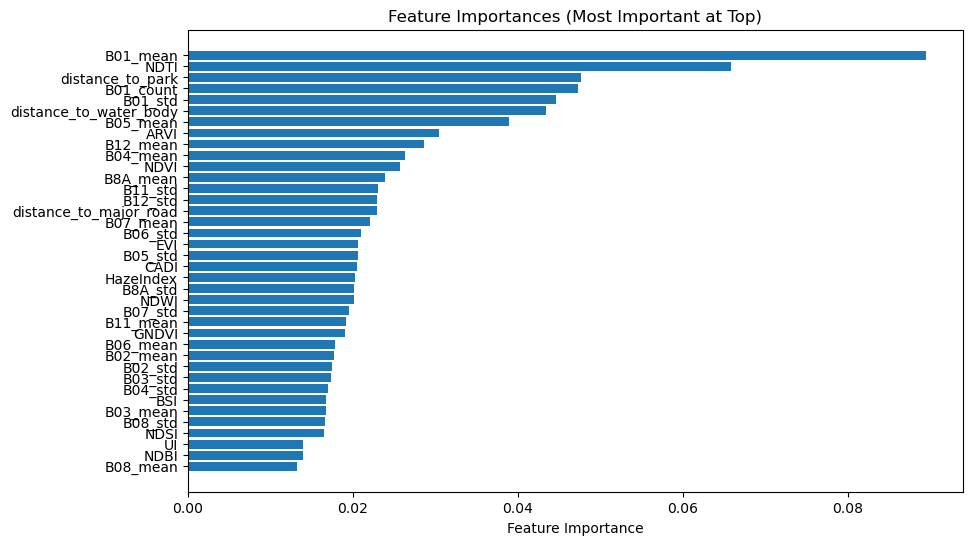

In [567]:
# Plot importances
plot_feature_importances(
    model= model,
    feature_names = uhi_data_X,
    export=False)

The horizontal bar chart ranks all 38 features by their relative contribution to the model, with **B01_mean** (mean reflectance in Band 1) emerging as the strongest predictor. Next in importance are the moisture‐sensitive **NDII** index and the spatial feature **distance_to_park**, highlighting the roles of surface wetness and green space proximity in modulating UHI intensity. 

Additional top predictors include spectral stats like **B01_count** and **B01_std**, alongside **distance_to_water_body**, underscoring the cooling impacts of nearby water. Importance values then gradually taper off across other indices and features, with **distance_to_major_road** ranking mid‐list and anthropogenic‐heat proxies like **UI** and **NDBI** appearing near the bottom.  

This distribution shows the model relies most heavily on a handful of spectral and spatial features, while many variables have only marginal influence on UHI predictions. However, when dropping these features from the model, we see the model performance drop, hence we leave them in.

## Submission Maryland

In [504]:
#Reading the coordinates for the submission
test_file = pd.read_csv("./Submission_Template_Hult_Maryland (1).csv")
test_file.head()

Longitude   Latitude  UHI Index
0 -77.301697  39.109247        NaN
1 -77.300382  39.113362        NaN
2 -77.300285  39.108433        NaN
3 -77.299315  39.107880        NaN
4 -77.299300  39.115225        NaN

In [520]:
# Mapping our TIFF images data to our Submission file

tiff_paths = [
     "./TIFF MONT_80SQM/SMALL_time4_.tiff",   
        "./TIFF MONT_80SQM/SMALL_time3_.tiff",   
        "./TIFF MONT_80SQM/SMALL_time2_.tiff",   
        "./TIFF MONT_80SQM/SMALL_time1_.tiff",   
        "./TIFF MONT_80SQM/SMALL_time0_.tiff",  
        "./TIFF MONT_80SQM/small_box2_0.tiff",   
        "./TIFF MONT_80SQM/small_box2_1.tiff",   
        "./TIFF MONT_80SQM/small_box2_6.tiff",   
        "./TIFF MONT_80SQM/small_box2_9.tiff",   
        "./TIFF MONT_80SQM/small_box2_10.tiff", 
        "./TIFF MONT_80SQM/box3_time0_.tiff",   
        "./TIFF MONT_80SQM/box3_time4_.tiff",   
        "./TIFF MONT_80SQM/box3_time6_.tiff",   
        "./TIFF MONT_80SQM/box3_time9_.tiff",   
        "./TIFF MONT_80SQM/box3_time10_.tiff",
        "./TIFF MONT_80SQM/box5_time0_.tiff",   
        "./TIFF MONT_80SQM/box5_time1_.tiff",   
        "./TIFF MONT_80SQM/box5_time4_.tiff",   
        "./TIFF MONT_80SQM/box5_time5_.tiff",   
        "./TIFF MONT_80SQM/box5_time7_.tiff",
        "./TIFF MONT_80SQM/box6_time0_.tiff",   
        "./TIFF MONT_80SQM/box6_time5_.tiff",   
        "./TIFF MONT_80SQM/box6_time6_.tiff",   
        "./TIFF MONT_80SQM/box6_time9_.tiff",   
        "./TIFF MONT_80SQM/box6_time10_.tiff",
        "./TIFF MONT_80SQM/box7_time0_.tiff",   
        "./TIFF MONT_80SQM/box7_time4_.tiff",   
        "./TIFF MONT_80SQM/box7_time6_.tiff",   
        "./TIFF MONT_80SQM/box7_time9_.tiff",   
        "./TIFF MONT_80SQM/box7_time10_.tiff",
        "./TIFF MONT_80SQM/box8_time0_.tiff",   
        "./TIFF MONT_80SQM/box8_time1_.tiff",   
        "./TIFF MONT_80SQM/box8_time4_.tiff",   
        "./TIFF MONT_80SQM/box8_time5_.tiff",   
        "./TIFF MONT_80SQM/box8_time8_.tiff",
        "./TIFF MONT_80SQM/box9_time0_.tiff",   
        "./TIFF MONT_80SQM/box9_time3_.tiff",   
        "./TIFF MONT_80SQM/box9_time4_.tiff",   
        "./TIFF MONT_80SQM/box9_time5_.tiff",   
        "./TIFF MONT_80SQM/box9_time8_.tiff",
        "./TIFF MONT_80SQM/box10_time0_.tiff",  
        "./TIFF MONT_80SQM/box10_time1_.tiff",   
        "./TIFF MONT_80SQM/box10_time5_.tiff",   
        "./TIFF MONT_80SQM/box10_time7_.tiff",   
        "./TIFF MONT_80SQM/box10_time8_.tiff",
        "./TIFF MONT_80SQM/box11_time0_.tiff",   
        "./TIFF MONT_80SQM/box11_time4_.tiff",   
        "./TIFF MONT_80SQM/box11_time6_.tiff",   
        "./TIFF MONT_80SQM/box11_time9_.tiff",   
        "./TIFF MONT_80SQM/box11_time10_.tiff",
        "./TIFF MONT_80SQM/box12_time0_.tiff",   
        "./TIFF MONT_80SQM/box12_time6_.tiff",   
        "./TIFF MONT_80SQM/box12_time9_.tiff",   
        "./TIFF MONT_80SQM/box12_time10_.tiff",
        "./TIFF MONT_80SQM/box13_time0_.tiff",   
        "./TIFF MONT_80SQM/box13_time1_.tiff",   
        "./TIFF MONT_80SQM/box13_time4_.tiff",   
        "./TIFF MONT_80SQM/box13_time5_.tiff",   
        "./TIFF MONT_80SQM/box13_time8_.tiff" 
]
submission_csv = "./Submission_Template_Hult_Maryland (1).csv"

# 1) compute your summary (means + stds)
submission_summary = map_satellite_data_with_fill(tiff_paths, submission_csv)

# 2) merge back any extra columns in your template
template = pd.read_csv(submission_csv)
final = template.merge(
    submission_summary,
    on=["Latitude","Longitude"],
    how="left"
)

# 3) saving to a csv file
final.to_csv("./Submission_with_SatFeatures_Maryland_FinalModel_nontrained.csv", index=False)
print("Got", final.shape[0], "rows ×", final.shape[1], "columns")

Mapping ./TIFF MONT_80SQM/SMALL_time4_.tiff: 100%|█| 3834/3834 [00:01<00:00, 323
Mapping ./TIFF MONT_80SQM/SMALL_time3_.tiff: 100%|█| 3834/3834 [00:01<00:00, 330
Mapping ./TIFF MONT_80SQM/SMALL_time2_.tiff: 100%|█| 3834/3834 [00:01<00:00, 363
Mapping ./TIFF MONT_80SQM/SMALL_time1_.tiff: 100%|█| 3834/3834 [00:01<00:00, 369
Mapping ./TIFF MONT_80SQM/SMALL_time0_.tiff: 100%|█| 3834/3834 [00:01<00:00, 364
Mapping ./TIFF MONT_80SQM/small_box2_0.tiff: 100%|█| 3834/3834 [00:02<00:00, 172
Mapping ./TIFF MONT_80SQM/small_box2_1.tiff: 100%|█| 3834/3834 [00:02<00:00, 171
Mapping ./TIFF MONT_80SQM/small_box2_6.tiff: 100%|█| 3834/3834 [00:02<00:00, 170
Mapping ./TIFF MONT_80SQM/small_box2_9.tiff: 100%|█| 3834/3834 [00:02<00:00, 172
Mapping ./TIFF MONT_80SQM/small_box2_10.tiff: 100%|█| 3834/3834 [00:02<00:00, 17
Mapping ./TIFF MONT_80SQM/box3_time0_.tiff: 100%|█| 3834/3834 [00:01<00:00, 2201
Mapping ./TIFF MONT_80SQM/box3_time4_.tiff: 100%|█| 3834/3834 [00:01<00:00, 2186
Mapping ./TIFF MONT_80SQM/bo

Got 3834 rows × 36 columns


In [532]:
# Reading in the data and checking the data
val_data = pd.read_csv("./Submission_with_SatFeatures_Maryland_FinalModel_nontrained.csv")
val_data.head()

Longitude   Latitude  UHI Index  B01_mean    B01_std  B01_count  B02_mean  \
0 -77.301697  39.109247        NaN    1380.2  38.217274          0    1594.2   
1 -77.300382  39.113362        NaN    1332.0  67.064148          0    1488.2   
2 -77.300285  39.108433        NaN    1380.2  38.217274          0    1594.2   
3 -77.299315  39.107880        NaN    1380.2  38.217274          0    1594.2   
4 -77.299300  39.115225        NaN    1332.0  67.064148          0    1488.2   

    B02_std  B02_count  B03_mean  ...  B08_count  B8A_mean     B8A_std  \
0  37.42940          0    1787.0  ...          0    4497.4  148.087272   
1  45.16813          0    1705.4  ...          0    4588.8  220.721000   
2  37.42940          0    1787.0  ...          0    4497.4  148.087272   
3  37.42940          0    1787.0  ...          0    4497.4  148.087272   
4  45.16813          0    1705.4  ...          0    4588.8  220.721000   

   B8A_count  B11_mean     B11_std  B11_count  B12_mean    B12_std  B12_count  
0          0    2975.2   76.887970          0    2041.8  65.764428          0  
1          0    2820.0  102.765753          0    1904.6  50.221908          0  
2          0    2975.2   76.887970          0    2041.8  65.764428          0  
3          0    2975.2   76.887970          0    2041.8  65.764428          0  
4          0    2820.0  102.765753          0    1904.6  50.221908          0  

[5 rows x 36 columns]

In [533]:
# Applying the features we made for our train data
import numpy as np

# flat feature calculations on val_data
val_data['NDVI']          = (val_data['B08_mean'] - val_data['B04_mean']) /
                            (val_data['B08_mean'] + val_data['B04_mean'])
    
val_data['NDWI']          = (val_data['B03_mean'] - val_data['B08_mean']) /
                            (val_data['B03_mean'] + val_data['B08_mean'])
    
val_data['NDBI']          = (val_data['B11_mean'] - val_data['B08_mean']) / 
                            (val_data['B11_mean'] + val_data['B08_mean'])
    
val_data['GNDVI']         = (val_data['B08_mean'] - val_data['B03_mean']) /
                            (val_data['B08_mean'] + val_data['B03_mean'])
    
val_data['ARVI']          = (val_data['B08_mean'] - 2*val_data['B04_mean'] + 
                             val_data['B02_mean']) / (val_data['B08_mean'] + 
                             2*val_data['B04_mean'] - val_data['B02_mean'])

val_data['EVI']           = 2.5*(val_data['B08_mean'] - val_data['B04_mean']) / 
                            (val_data['B08_mean'] + 6*val_data['B04_mean'] - 7.5*val_data['B02_mean'] + 1)
    
val_data['NDSI']          = (val_data['B03_mean'] - val_data['B11_mean']) / 
                            (val_data['B03_mean'] + val_data['B11_mean'])
    
val_data['BSI']           = ((val_data['B11_mean'] + val_data['B04_mean']) - 
                             (val_data['B08_mean'] + val_data['B02_mean'])) /
                            ((val_data['B11_mean'] + val_data['B04_mean']) +
                             (val_data['B08_mean'] + val_data['B02_mean']))
    
val_data['NDTI']          = (val_data['B11_mean'] - val_data['B12_mean']) /
                            (val_data['B11_mean'] + val_data['B12_mean'])
    
val_data['CADI']          = (val_data['B01_mean'] - val_data['B02_mean']) / 
                            (val_data['B01_mean'] + val_data['B02_mean'])
    
val_data['HazeIndex']     = (val_data['B02_mean'] - val_data['B01_mean']) /
                            (val_data['B02_mean'] + val_data['B01_mean'])
    
val_data['is_hazy']       = (val_data['B01_mean'] > val_data['B01_mean'].quantile(0.95)).astype(int)

val_data['UI']            = (val_data['B11_mean'] - (val_data['B08_mean'] +
                            val_data['B04_mean'])) / (val_data['B11_mean'] + val_data['B08_mean']
                            + val_data['B04_mean'])

# clean up infinities/NaNs
val_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [534]:
# Applying the features we made for our train data

# ───────────────────────────────────────────────────────────────
# 1) Prepare your validation points GeoDataFrame
# ───────────────────────────────────────────────────────────────
val_gdf = gpd.GeoDataFrame(
    val_data,  # your validation DataFrame
    geometry=gpd.points_from_xy(
        val_data['Longitude'], val_data['Latitude']
    ),
    crs="EPSG:4326"
)

# ───────────────────────────────────────────────────────────────
# 2) Load & stack the water‐bodies + flowlines
# ───────────────────────────────────────────────────────────────
water_shp    = "./NHD_H_Maryland_State_Shape/Shape/NHDWaterbody.shp"
flowline_shp = "./NHD_H_Maryland_State_Shape/Shape/NHDFlowline.shp"

water_bodies = gpd.read_file(water_shp)
flow_lines   = gpd.read_file(flowline_shp)

water_all = gpd.GeoDataFrame(
    pd.concat([water_bodies, flow_lines], ignore_index=True),
    crs=water_bodies.crs
)

# ───────────────────────────────────────────────────────────────
# 3) Reproject to a meter‐based CRS for accurate distances
# ───────────────────────────────────────────────────────────────
proj_crs   = "EPSG:26918"  # NAD83 / UTM zone 18N
val_proj   = val_gdf.to_crs(proj_crs)
water_proj = water_all.to_crs(proj_crs)

# ───────────────────────────────────────────────────────────────
# 4) Nearest‐feature join, pulling in the distance
# ───────────────────────────────────────────────────────────────
joined = sjoin_nearest(
    val_proj,
    water_proj[['geometry']],
    how='left',
    distance_col='distance_to_water_body'
)

# ───────────────────────────────────────────────────────────────
# 5) De‐duplicate so each original index appears only once
# ───────────────────────────────────────────────────────────────
joined = joined[~joined.index.duplicated(keep='first')]

# ───────────────────────────────────────────────────────────────
# 6) Assign back into validation DataFrame
# ───────────────────────────────────────────────────────────────
val_data['distance_to_water_body'] = joined['distance_to_water_body']

In [535]:
# Applying the features we made for our train data

# ───────────────────────────────────────────────────────────────
# 1) Prepare your validation points GeoDataFrame
# ───────────────────────────────────────────────────────────────
val_gdf = gpd.GeoDataFrame(
    val_data,
    geometry=gpd.points_from_xy(
        val_data['Longitude'],
        val_data['Latitude']
    ),
    crs="EPSG:4326"
)

# ───────────────────────────────────────────────────────────────
# 2) Inspect & load the PADUS “combined” parks layer
# ───────────────────────────────────────────────────────────────
gdb_path = "./PADUS4_1_State_MD_GDB_KMZ/PADUS4_1_StateMD.gdb"  # ← adjust as needed

# (optional) print available layers to pick the correct one
print(fiona.listlayers(gdb_path))
# e.g.: [
#   'PADUS4_1Fee_State_MD',
#   'PADUS4_1Easement_State_MD',
#   'PADUS4_1Proclamation_State_MD',
#   'PADUS4_1Comb_DOD_Trib_NGP_Fee_Desig_Ease_State_MD',
#   …
# ]

combined_layer = "PADUS4_1Comb_DOD_Trib_NGP_Fee_Desig_Ease_State_MD"

parks = gpd.read_file(
    gdb_path,
    layer=combined_layer
)

# ───────────────────────────────────────────────────────────────
# 3) Reproject both to a meter‐based CRS for accurate distances
# ───────────────────────────────────────────────────────────────
proj_crs   = "EPSG:26918"  # NAD83 / UTM zone 18N
val_proj   = val_gdf.to_crs(proj_crs)
parks_proj = parks.to_crs(proj_crs)

# ───────────────────────────────────────────────────────────────
# 4) Nearest‐feature join to compute distance_to_park (meters)
# ───────────────────────────────────────────────────────────────
joined = sjoin_nearest(
    val_proj,
    parks_proj[['geometry']],
    how='left',
    distance_col='distance_to_park'
)

# ───────────────────────────────────────────────────────────────
# 5) Drop any exact‐distance ties so each validation point appears once
# ───────────────────────────────────────────────────────────────
joined = joined[~joined.index.duplicated(keep='first')]

# ───────────────────────────────────────────────────────────────
# 6) Assign the new feature back into validation DataFrame
# ───────────────────────────────────────────────────────────────
val_data['distance_to_park'] = joined['distance_to_park']

['PADUS4_1Fee_State_MD', 'PADUS4_1Easement_State_MD', 'PADUS4_1Proclamation_State_MD', 'PADUS4_1Comb_DOD_Trib_NGP_Fee_Desig_Ease_State_MD', 'PADUS4_1Designation_State_MD', 'PADUS4_1Marine', 'Public_Access', 'Agency_Name', 'Agency_Type', 'Category', 'Designation_Type', 'GAP_Status', 'IUCN_Category', 'State_Name']


In [536]:
# Applying the features we made for our train data

# ───────────────────────────────────────────────────────────────
# 0) Prepare your validation GeoDataFrame (projected)
# ───────────────────────────────────────────────────────────────
proj_crs = "EPSG:26918"  # UTM zone 18N for Maryland
val_gdf = gpd.GeoDataFrame(
    val_data,
    geometry=gpd.points_from_xy(
        val_data.Longitude,
        val_data.Latitude
    ),
    crs="EPSG:4326"
).to_crs(proj_crs)

# ───────────────────────────────────────────────────────────────
# 1) Geocode Montgomery County → get its boundary Polygon
# ───────────────────────────────────────────────────────────────
county_gdf = ox.geocoder.geocode_to_gdf("Montgomery County, Maryland, USA")
county_polygon = unary_union(county_gdf.geometry)

# ───────────────────────────────────────────────────────────────
# 2) Build the drivable‐road network from that Polygon
# ───────────────────────────────────────────────────────────────
G = ox.graph_from_polygon(county_polygon, network_type="drive")
roads_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)

# ensure the roads are in our projected CRS
roads_gdf = (roads_gdf
             .set_crs("EPSG:4326", allow_override=True)
             .to_crs(proj_crs))

# ───────────────────────────────────────────────────────────────
# 3) Compute distance_to_major_road via nearest‐join
# ───────────────────────────────────────────────────────────────
joined = sjoin_nearest(
    val_gdf,
    roads_gdf[['geometry']],
    how='left',
    distance_col='distance_to_major_road'
)

# drop any exact‐distance ties so each validation index appears once
joined = joined[~joined.index.duplicated(keep='first')]

# ───────────────────────────────────────────────────────────────
# 4) Assign the result back into validation DataFrame
# ───────────────────────────────────────────────────────────────
val_data['distance_to_major_road'] = joined['distance_to_major_road']

In [537]:
# Checking the data if all columns are there
val_data.head()

Longitude   Latitude  UHI Index  B01_mean    B01_std  B01_count  B02_mean  \
0 -77.301697  39.109247        NaN    1380.2  38.217274          0    1594.2   
1 -77.300382  39.113362        NaN    1332.0  67.064148          0    1488.2   
2 -77.300285  39.108433        NaN    1380.2  38.217274          0    1594.2   
3 -77.299315  39.107880        NaN    1380.2  38.217274          0    1594.2   
4 -77.299300  39.115225        NaN    1332.0  67.064148          0    1488.2   

    B02_std  B02_count  B03_mean  ...      NDSI       BSI      NDTI      CADI  \
0  37.42940          0    1787.0  ... -0.249507 -0.076746  0.186047 -0.071947   
1  45.16813          0    1705.4  ... -0.246299 -0.128526  0.193752 -0.055386   
2  37.42940          0    1787.0  ... -0.249507 -0.076746  0.186047 -0.071947   
3  37.42940          0    1787.0  ... -0.249507 -0.076746  0.186047 -0.071947   
4  45.16813          0    1705.4  ... -0.246299 -0.128526  0.193752 -0.055386   

   HazeIndex  is_hazy        UI  distance_to_water_body  distance_to_park  \
0   0.071947        0 -0.300282              111.592968         71.785661   
1   0.055386        0 -0.333333              239.208234        280.328192   
2   0.071947        0 -0.300282               12.052645         74.165033   
3   0.071947        0 -0.300282               84.678334        129.172983   
4   0.055386        0 -0.333333              227.463162        382.221584   

   distance_to_major_road  
0                7.074794  
1                8.558096  
2                3.257089  
3                0.327192  
4                7.100451  

[5 rows x 52 columns]

In [538]:
# Dropping Longitude and Latitude from our validation data
submission_val_data = val_data.drop(['Longitude', 'Latitude'], axis=1)
submission_val_data.head()

['UHI Index', 'B01_mean', 'B01_std', 'B01_count', 'B02_mean', 'B02_std', 'B02_count', 'B03_mean', 'B03_std', 'B03_count', 'B04_mean', 'B04_std', 'B04_count', 'B05_mean', 'B05_std', 'B05_count', 'B06_mean', 'B06_std', 'B06_count', 'B07_mean', 'B07_std', 'B07_count', 'B08_mean', 'B08_std', 'B08_count', 'B8A_mean', 'B8A_std', 'B8A_count', 'B11_mean', 'B11_std', 'B11_count', 'B12_mean', 'B12_std', 'B12_count', 'NDVI', 'NDWI', 'NDBI', 'GNDVI', 'ARVI', 'EVI', 'NDSI', 'BSI', 'NDTI', 'CADI', 'HazeIndex', 'is_hazy', 'UI', 'distance_to_water_body', 'distance_to_park', 'distance_to_major_road']


In [539]:
# Selecting the features we will use in the final model 
submission_val_data = val_data[['B01_mean', 'B01_std','B01_count', 
                                'B02_mean', 'B02_std', 'B03_mean', 'B03_std',
                                'B04_mean', 'B04_std', 'B05_mean', 'B05_std',
                                'B06_mean', 'B06_std', 'B07_mean', 'B07_std',
                                'B08_mean', 'B08_std', 'B8A_mean', 'B8A_std',
                                'B11_mean', 'B11_std', 'B12_mean', 'B12_std',
                                'NDVI', 'NDWI', 'NDBI', 'GNDVI', 'ARVI', 'EVI', 'NDSI',
                                'BSI', 'NDTI', 'CADI', 'HazeIndex', 'UI',
                                'distance_to_water_body', 'distance_to_park', 'distance_to_major_road']]

In [540]:
#Making predictions
final_predictions = tuned_rf.predict(submission_val_data)
final_prediction_series = pd.Series(final_predictions)

In [541]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values,
                              'Latitude':test_file['Latitude'].values,
                              'UHI Index':final_prediction_series.values})

In [542]:
#Displaying the sample submission dataframe
submission_df.head()

Longitude   Latitude  UHI Index
0 -77.301697  39.109247   0.980881
1 -77.300382  39.113362   0.978427
2 -77.300285  39.108433   0.979925
3 -77.299315  39.107880   0.979442
4 -77.299300  39.115225   0.978549

In [543]:
#Saving the predictions into a csv file.
submission_df.to_csv("Predicted_Data_Final_Maryland.csv",index = False)

## Submission NYC

In [544]:
#Reading the coordinates for the submission
test_file = pd.read_csv("./Submission_Template_Hult_NYC.csv")
test_file.head()

Longitude   Latitude  UHI Index
0 -73.971665  40.788763        NaN
1 -73.971928  40.788875        NaN
2 -73.967080  40.789080        NaN
3 -73.972550  40.789082        NaN
4 -73.969697  40.787953        NaN

In [545]:
# Mapping our TIFF images data to our Submission file for NYC

# your three TIFFs
tiff_paths = [
     "NYC_0.tiff",   
     "NYC_1.tiff",   
     "NYC_9.tiff",]

submission_csv = "./Submission_Template_Hult_NYC.csv"

# 1) compute your summary (means + stds)
submission_summary = map_satellite_data_with_fill(tiff_paths, submission_csv)

# 2) merge back any extra columns in your template
template = pd.read_csv(submission_csv)
final = template.merge(
    submission_summary,
    on=["Latitude","Longitude"],
    how="left"
)

# 3) saving to csv
final.to_csv("./Submission_with_SatFeatures_NYC_FinalModel_trained.csv", index=False)
print("Got", final.shape[0], "rows ×", final.shape[1], "columns")

Mapping NYC_9.tiff: 100%|██████████████████| 1040/1040 [00:03<00:00, 289.54it/s]

Got 1040 rows × 36 columns


In [546]:
# Reading in the data and checking the data
val_data = pd.read_csv("./Submission_with_SatFeatures_NYC_FinalModel_trained.csv")
val_data.head()

Longitude   Latitude  UHI Index     B01_mean     B01_std  B01_count  \
0 -73.971665  40.788763        NaN   754.333333   60.389477          3   
1 -73.971928  40.788875        NaN  1184.000000   70.743669          3   
2 -73.967080  40.789080        NaN   969.333333  179.165349          3   
3 -73.972550  40.789082        NaN  1168.666667   80.508109          3   
4 -73.969697  40.787953        NaN  1010.000000   44.996296          3   

     B02_mean     B02_std  B02_count     B03_mean  ...  B08_count  \
0  413.333333   69.887211          3   563.666667  ...          3   
1  497.666667   47.835366          3   682.333333  ...          3   
2  823.000000   42.055519          3   935.666667  ...          3   
3  863.666667   45.433712          3   941.666667  ...          3   
4  942.666667  344.876145          3  1185.000000  ...          3   

      B8A_mean     B8A_std  B8A_count     B11_mean     B11_std  B11_count  \
0  2654.666667  216.248828          3  1650.333333  229.587069          3   
1  3014.333333  443.042762          3  1947.666667  238.844906          3   
2  1497.000000  391.001279          3  1361.666667  402.227409          3   
3  2002.333333   76.111030          3  2446.333333  134.527155          3   
4  2777.666667  260.819648          3  2072.666667   55.101926          3   

      B12_mean     B12_std  B12_count  
0  1087.333333  212.228389          3  
1  1383.666667  231.756098          3  
2  1110.000000  352.934366          3  
3  2191.000000   52.083267          3  
4  1621.333333   64.188957          3  

[5 rows x 36 columns]

In [547]:
# Creating the features we used in our training data

# flat feature calculations on val_data
val_data['NDVI']          = (val_data['B08_mean'] - val_data['B04_mean']) /
                            (val_data['B08_mean'] + val_data['B04_mean'])
    
val_data['NDWI']          = (val_data['B03_mean'] - val_data['B08_mean']) /
                            (val_data['B03_mean'] + val_data['B08_mean'])
    
val_data['NDBI']          = (val_data['B11_mean'] - val_data['B08_mean']) / 
                            (val_data['B11_mean'] + val_data['B08_mean'])
    
val_data['GNDVI']         = (val_data['B08_mean'] - val_data['B03_mean']) /
                            (val_data['B08_mean'] + val_data['B03_mean'])
    
val_data['ARVI']          = (val_data['B08_mean'] - 2*val_data['B04_mean'] + 
                             val_data['B02_mean']) / (val_data['B08_mean'] + 
                             2*val_data['B04_mean'] - val_data['B02_mean'])

val_data['EVI']           = 2.5*(val_data['B08_mean'] - val_data['B04_mean']) / 
                            (val_data['B08_mean'] + 6*val_data['B04_mean'] - 7.5*val_data['B02_mean'] + 1)
    
val_data['NDSI']          = (val_data['B03_mean'] - val_data['B11_mean']) / 
                            (val_data['B03_mean'] + val_data['B11_mean'])
    
val_data['BSI']           = ((val_data['B11_mean'] + val_data['B04_mean']) - 
                             (val_data['B08_mean'] + val_data['B02_mean'])) /
                            ((val_data['B11_mean'] + val_data['B04_mean']) +
                             (val_data['B08_mean'] + val_data['B02_mean']))
    
val_data['NDTI']          = (val_data['B11_mean'] - val_data['B12_mean']) /
                            (val_data['B11_mean'] + val_data['B12_mean'])
    
val_data['CADI']          = (val_data['B01_mean'] - val_data['B02_mean']) / 
                            (val_data['B01_mean'] + val_data['B02_mean'])
    
val_data['HazeIndex']     = (val_data['B02_mean'] - val_data['B01_mean']) /
                            (val_data['B02_mean'] + val_data['B01_mean'])
    
val_data['is_hazy']       = (val_data['B01_mean'] > val_data['B01_mean'].quantile(0.95)).astype(int)

val_data['UI']            = (val_data['B11_mean'] - (val_data['B08_mean'] +
                            val_data['B04_mean'])) / (val_data['B11_mean'] + val_data['B08_mean']
                            + val_data['B04_mean'])

# clean up infinities/NaNs
val_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [548]:
# Creating the features we used in our training data

# ───────────────────────────────────────────────────────────────
# 1) Prepare your validation points GeoDataFrame
# ───────────────────────────────────────────────────────────────
val_gdf = gpd.GeoDataFrame(
    val_data,  # your validation DataFrame
    geometry=gpd.points_from_xy(
        val_data['Longitude'], val_data['Latitude']
    ),
    crs="EPSG:4326"
)

# ───────────────────────────────────────────────────────────────
# 2) Load & stack the water‐bodies + flowlines
# ───────────────────────────────────────────────────────────────
water_shp    = "./NHD_H_New_York_State_Shape/Shape/NHDWaterbody.shp"
flowline_shp = "./NHD_H_New_York_State_Shape/Shape/NHDFlowline.shp"

water_bodies = gpd.read_file(water_shp)
flow_lines   = gpd.read_file(flowline_shp)

water_all = gpd.GeoDataFrame(
    pd.concat([water_bodies, flow_lines], ignore_index=True),
    crs=water_bodies.crs
)

# ───────────────────────────────────────────────────────────────
# 3) Reproject to a meter‐based CRS for accurate distances
# ───────────────────────────────────────────────────────────────
proj_crs   = "EPSG:26918"  # NAD83 / UTM zone 18N
val_proj   = val_gdf.to_crs(proj_crs)
water_proj = water_all.to_crs(proj_crs)

# ───────────────────────────────────────────────────────────────
# 4) Nearest‐feature join, pulling in the distance
# ───────────────────────────────────────────────────────────────
joined = sjoin_nearest(
    val_proj,
    water_proj[['geometry']],
    how='left',
    distance_col='distance_to_water_body'
)

# ───────────────────────────────────────────────────────────────
# 5) De‐duplicate so each original index appears only once
# ───────────────────────────────────────────────────────────────
joined = joined[~joined.index.duplicated(keep='first')]

# ───────────────────────────────────────────────────────────────
# 6) Assign back into validation DataFrame
# ───────────────────────────────────────────────────────────────
val_data['distance_to_water_body'] = joined['distance_to_water_body']

In [549]:
# Creating the features we used in our training data

# ───────────────────────────────────────────────────────────────
# 1) Prepare your validation points GeoDataFrame
# ───────────────────────────────────────────────────────────────
val_gdf = gpd.GeoDataFrame(
    val_data,
    geometry=gpd.points_from_xy(
        val_data['Longitude'],
        val_data['Latitude']
    ),
    crs="EPSG:4326"
)

# ───────────────────────────────────────────────────────────────
# 2) Inspect & load the PADUS “combined” parks layer
# ───────────────────────────────────────────────────────────────
gdb_path = "./PADUS4_1_State_NY_GDB_KMZ/PADUS4_1_StateNY.gdb"  # ← adjust as needed

# (optional) print available layers to pick the correct one
print(fiona.listlayers(gdb_path))
# e.g.: [
#   'PADUS4_1Fee_State_MD',
#   'PADUS4_1Easement_State_MD',
#   'PADUS4_1Proclamation_State_MD',
#   'PADUS4_1Comb_DOD_Trib_NGP_Fee_Desig_Ease_State_MD',
#   …
# ]

combined_layer = "PADUS4_1Comb_DOD_Trib_NGP_Fee_Desig_Ease_State_NY"

parks = gpd.read_file(
    gdb_path,
    layer=combined_layer
)

# ───────────────────────────────────────────────────────────────
# 3) Reproject both to a meter‐based CRS for accurate distances
# ───────────────────────────────────────────────────────────────
proj_crs   = "EPSG:26918"  # NAD83 / UTM zone 18N
val_proj   = val_gdf.to_crs(proj_crs)
parks_proj = parks.to_crs(proj_crs)

# ───────────────────────────────────────────────────────────────
# 4) Nearest‐feature join to compute distance_to_park (meters)
# ───────────────────────────────────────────────────────────────
joined = sjoin_nearest(
    val_proj,
    parks_proj[['geometry']],
    how='left',
    distance_col='distance_to_park'
)

# ───────────────────────────────────────────────────────────────
# 5) Drop any exact‐distance ties so each validation point appears once
# ───────────────────────────────────────────────────────────────
joined = joined[~joined.index.duplicated(keep='first')]

# ───────────────────────────────────────────────────────────────
# 6) Assign the new feature back into validation DataFrame
# ───────────────────────────────────────────────────────────────
val_data['distance_to_park'] = joined['distance_to_park']

['PADUS4_1Fee_State_NY', 'PADUS4_1Easement_State_NY', 'PADUS4_1Proclamation_State_NY', 'PADUS4_1Comb_DOD_Trib_NGP_Fee_Desig_Ease_State_NY', 'PADUS4_1Designation_State_NY', 'PADUS4_1Marine', 'Public_Access', 'Agency_Name', 'Agency_Type', 'Category', 'Designation_Type', 'GAP_Status', 'IUCN_Category', 'State_Name']


In [550]:
# Creating the features we used in our training data

# ───────────────────────────────────────────────────────────────
# 0) Prepare your validation GeoDataFrame (projected)
# ───────────────────────────────────────────────────────────────
proj_crs = "EPSG:26918"  # UTM zone 18N still covers NYC in meters
val_gdf = gpd.GeoDataFrame(
    val_data,
    geometry=gpd.points_from_xy(val_data.Longitude, val_data.Latitude),
    crs="EPSG:4326"
).to_crs(proj_crs)

# ───────────────────────────────────────────────────────────────
# 1) Geocode New York City → get its boundary Polygon
# ───────────────────────────────────────────────────────────────
nyc_gdf      = ox.geocoder.geocode_to_gdf("New York City, New York, USA")
nyc_polygon  = unary_union(nyc_gdf.geometry)

# ───────────────────────────────────────────────────────────────
# 2) Build the drivable‐road network from that Polygon
# ───────────────────────────────────────────────────────────────
G_nyc        = ox.graph_from_polygon(nyc_polygon, network_type="drive")
roads_nyc    = ox.graph_to_gdfs(G_nyc, nodes=False, edges=True)

# ensure CRS matches
roads_nyc = (roads_nyc
             .set_crs("EPSG:4326", allow_override=True)
             .to_crs(proj_crs))

# ───────────────────────────────────────────────────────────────
# 3) Compute distance_to_major_road via nearest‐join
# ───────────────────────────────────────────────────────────────
joined_nyc = sjoin_nearest(
    val_gdf,
    roads_nyc[['geometry']],
    how='left',
    distance_col='distance_to_major_road'
)

# drop any exact‐distance ties
joined_nyc = joined_nyc[~joined_nyc.index.duplicated(keep='first')]

# ───────────────────────────────────────────────────────────────
# 4) Assign back into validation DataFrame
# ───────────────────────────────────────────────────────────────
val_data['distance_to_major_road'] = joined_nyc['distance_to_major_road']

In [551]:
# Checking the data
val_data.head()

Longitude   Latitude  UHI Index     B01_mean     B01_std  B01_count  \
0 -73.971665  40.788763        NaN   754.333333   60.389477          3   
1 -73.971928  40.788875        NaN  1184.000000   70.743669          3   
2 -73.967080  40.789080        NaN   969.333333  179.165349          3   
3 -73.972550  40.789082        NaN  1168.666667   80.508109          3   
4 -73.969697  40.787953        NaN  1010.000000   44.996296          3   

     B02_mean     B02_std  B02_count     B03_mean  ...      NDSI       BSI  \
0  413.333333   69.887211          3   563.666667  ... -0.490816 -0.130867   
1  497.666667   47.835366          3   682.333333  ... -0.481115 -0.252154   
2  823.000000   42.055519          3   935.666667  ... -0.185432  0.049417   
3  863.666667   45.433712          3   941.666667  ... -0.444116  0.216089   
4  942.666667  344.876145          3  1185.000000  ... -0.272485 -0.115003   

       NDTI      CADI  HazeIndex  is_hazy        UI  distance_to_water_body  \
0  0.205650  0.292035  -0.292035        0 -0.263189              488.982124   
1  0.169302  0.408127  -0.408127        0 -0.363369              513.771118   
2  0.101821  0.081644  -0.081644        0 -0.273842              172.547218   
3  0.055060  0.150074  -0.150074        0 -0.010716              570.621522   
4  0.122180  0.034483  -0.034483        0 -0.336888              304.768982   

   distance_to_park  distance_to_major_road  
0          5.195312                3.647875  
1          5.279378                3.523951  
2         51.884082               25.181607  
3         45.370708                8.768128  
4        124.044164                1.946631  

[5 rows x 52 columns]

In [552]:
# Dropping Longitude and Latitude from our validation data
submission_val_data = val_data.drop(['Longitude', 'Latitude'], axis=1)
submission_val_data.head()

['UHI Index', 'B01_mean', 'B01_std', 'B01_count', 'B02_mean', 'B02_std', 'B02_count', 'B03_mean', 'B03_std', 'B03_count', 'B04_mean', 'B04_std', 'B04_count', 'B05_mean', 'B05_std', 'B05_count', 'B06_mean', 'B06_std', 'B06_count', 'B07_mean', 'B07_std', 'B07_count', 'B08_mean', 'B08_std', 'B08_count', 'B8A_mean', 'B8A_std', 'B8A_count', 'B11_mean', 'B11_std', 'B11_count', 'B12_mean', 'B12_std', 'B12_count', 'NDVI', 'NDWI', 'NDBI', 'GNDVI', 'ARVI', 'EVI', 'NDSI', 'BSI', 'NDTI', 'CADI', 'HazeIndex', 'is_hazy', 'UI', 'distance_to_water_body', 'distance_to_park', 'distance_to_major_road']


In [553]:
# Selecting the features we will use in the final model 
submission_val_data = val_data[['B01_mean', 'B01_std','B01_count', 
                                'B02_mean', 'B02_std', 'B03_mean', 'B03_std',
                                'B04_mean', 'B04_std', 'B05_mean', 'B05_std',
                                'B06_mean', 'B06_std', 'B07_mean', 'B07_std',
                                'B08_mean', 'B08_std', 'B8A_mean', 'B8A_std',
                                'B11_mean', 'B11_std', 'B12_mean', 'B12_std',
                                'NDVI', 'NDWI', 'NDBI', 'GNDVI', 'ARVI', 'EVI', 'NDSI',
                                'BSI', 'NDTI', 'CADI', 'HazeIndex', 'UI',
                                'distance_to_water_body', 'distance_to_park', 'distance_to_major_road']]

In [554]:
#Making predictions
final_predictions = tuned_rf.predict(submission_val_data)
final_prediction_series = pd.Series(final_predictions)

In [555]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values,
                              'Latitude':test_file['Latitude'].values,
                              'UHI Index':final_prediction_series.values})

In [556]:
#Displaying the sample submission dataframe
submission_df.head()

Longitude   Latitude  UHI Index
0 -73.971665  40.788763   0.968553
1 -73.971928  40.788875   0.972405
2 -73.967080  40.789080   0.990935
3 -73.972550  40.789082   0.990061
4 -73.969697  40.787953   0.977810

In [557]:
#Saving the predictions into a csv file.
submission_df.to_csv("Predicted_Data_Final_NYC.csv",index = False)

## Analysis and Code
**Modelling**

Our modeling pipeline began with extensive preprocessing and exploration.
Our first thought, after facing problems related to multicollinearity, was to use Principal Component Analysis (PCA) to project the features down into fewer dimensions so that there wouldn't be any redundancy between similar points of data. While PCA could clean up the data and remove redundancy, it also made it harder to understand which of the original features were actually important, since PCA creates new "combined" features that don't really map back to the original inputs like distance from water or road. Not only that, but though, it helped stabilize the model, it reduced our prediction power to 0.15. Considering the context and goal of the project, we decided to focus on increasing the prediction power compared to having a very stable model but with a low R2.

Next, we tried Ordinary Least Squares (OLS) regression as our control model being useful to illustrate the interaction between inputs and output. But our data contained complex patterns, especially from satellite observations and spatial nature, which were not well captured by a simple linear model like OLS. We also tried Lasso regression, which helps to remove irrelevant features and prevent overfitting. But this resulted in losing crucial variables and did not do well, especially when we were working on smaller map regions (bounding boxes), so the model got too specialized in its knowledge.

Then we moved to more advanced machine learning models like XGBoost and Gradient Boosting Machines (GBM). They perform exceptionally well to detect complex patterns in the data, and they gave us high scores when we applied them on the training data. But they would fall off in accuracy if we tested them on new areas or with larger bounding boxes. That suggested the models were overfitting, learning too much from the training data and getting confused when shown anything new or different.

We noticed that changing the size of bounding boxes affected performance as well. The smaller boxes performed well in training but poorly when tested in the outside world. Larger boxes introduced diversity but the models were not able to handle such diversity properly. While some models were highly accurate (R²), the huge difference between training and testing performance told us that they were not reliable in real life.

After experimenting with all these models, we found that Random Forest mixed with multiple bounding boxes was the best trade-off. It minimized overfitting compared to the boosting models, and it performed better on both small and big bounding boxes. It was also more stable while switching between regions. Also, it gave us useful information about which features were most significant — something we lost when we applied PCA or more advanced models. 

Lastly we also tried to lower the number of features in our model to get to better results, but both the predictive power and train-test gap suffered from this. Hence we decided to include all features in the final model.

*Random Forest Modelling Method*:

To model the relationship between band features and the UHI index, we used Random Forest Regression from sklearn.ensemble. This ensemble-based method constructs multiple decision trees on random data subsets and aggregates their predictions to reduce variance and improve generalizability. Our final train-test split of the data was 80% training and 20% test data. We used three evaluation metrics: R2 Score , Mean Absolute Error (MAE) and Mean Squared Error (MSE) to evaluate the model.

**Results:**

- Train R2: 0.989 – Indicates near-perfect fit on the training data
- Test R2: 0.618 – Indicates moderate predictive power on unseen data
- MAE: ~0.115 – Suggests the model's average prediction deviated by 0.115 from the actual UHI index
- MSE: ~0.023 – Squared error remained low, indicating stable performance

The gap between the near-perfect training R² (0.989) and the moderate test R² (0.618) suggests the model is fitting noise, driven by the high-dimensional input space of 68 features acting on only ~60 locations. Moreover, relying on data from a single region and time period means the model hasn’t seen enough variability in UHI drivers, further limiting its ability to generalize.

**Comparing UHI - Maryland and NewYork**

We trained our model exclusively on Montgomery County, MD and then applied it — without any fine-tuning—to Manhattan, NY, where overall performance proved much lower. Although key hotspots like Lower Manhattan and the Bronx still emerged (as shown in the image below), the model struggled to capture the full range of UHI variability in a highly dense, high-rise environment. This drop in accuracy likely stems from stark differences in urban form (suburban sprawl versus vertical canyons), building materials (brick and glass façades versus asphalt and turf), and green-space layouts that alter spectral responses and thermal behavior. Distances between parks and water bodies in Manhattan are generally much shorter than in our Montgomery County training data, which likely threw the model off and resulted in worse results.

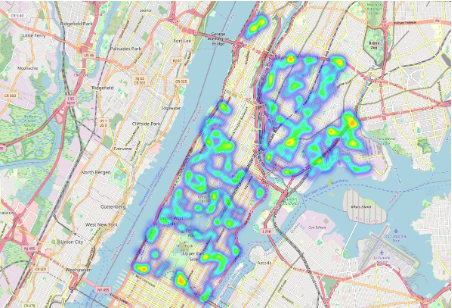

**Next Steps for the Analysis**

As a next step, based also on what the other groups presented, we would like to test our approach using a far larger bounding box. we would still like to include multiple images, even though this will heavily increase the storage and running time, to ensure we keep the data to a more generalizable model. Moreover, we would also like to test if all features would still be relevant in this model. We would also like to include a feature for relative elevation, as this could also significantly influence temperature. Lastly, to make the model more generalizable to other regions, we would like to experiment with adding weights to the data coming from urban vs. rural areas. Our current training set is quite rural and hence, won't work well in an dense urban area like New York.


## Conclusion

This project developed an interpretable, data-driven model to predict Urban Heat Island (UHI) intensity using Sentinel-2 satellite imagery and Random Forest regression. By systematically employing bounding-box tiling across Montgomery County, Maryland, we ensured comprehensive spatial coverage and representation of diverse urban and non-urban areas. Our robust feature-engineering pipeline combined raw reflectance statistics from 59 TIFF images with validated spectral indices (e.g., NDVI, NDWI, NDBI, NDTI) to effectively quantify vegetation health, moisture levels, built-up intensity, and atmospheric pollution.

Additionally, spatial features—including distances to water bodies, parks, and major roads—provided further nuance by accounting for evaporative cooling, shading effects, and infrastructure-driven heat. The resulting model achieved excellent predictive performance on training data (R² = 0.989), though its accuracy notably declined when predicting new locations within Montgomery County (test R² = 0.618), and further decreased when tested in a distinctly different region, Manhattan, NY. This highlights a key limitation: the model’s current design struggles with generalizability across regions exhibiting different urban morphologies.

Nonetheless, the project offers valuable insights and actionable recommendations for urban planning, emphasizing green infrastructure expansion, reflective pavements, and strengthened pollution controls. By clearly linking UHI patterns to specific, interpretable features, this approach not only provides technical predictive capability but also serves as a practical, policy-relevant framework to guide cities toward greater climate resilience and urban sustainability.



## Bibliography

Du, H., Song, X., Jiang, H., Kan, Z., Wang, Z., & Cai, Y. (2023). Dominance of influencing factors on cooling effect of urban parks. Scientific Reports, 13, 9799. https://doi.org/10.1038/s41598-023-36904-9
Link

Du, H., Wang, D., Wang, Y., Zhao, X., Qin, F., & Jiang, H. (2019). Water Bodies' Cooling Effects on Urban Land Daytime Surface Temperature. Sustainability, 11(3), 787. https://doi.org/10.3390/su11030787
Link

García, M. M., Cuesta, F., Fernández, F., & Merino, J. (2020). Cooling effect of urban parks: A case study of Retiro Park. Environmental Sciences Europe, 32, 48. https://doi.org/10.1186/s12302-020-00393-7
Link

Global Business Outlook. (2023, March 15). Go green with GBO: How Singapore became a ‘City in a Garden’. Retrieved from https://globalbusinessoutlook.com/energy/go-green-with-gbo-how-singapore-became-city-in-a-garden/

Institute for European Environmental Policy (IEEP). (2024, January 12). Stockholm paving the way for a new zero emission zone for cleaner air and better health. Retrieved from https://ieep.eu/news/stockholm-paving-the-way-for-a-new-zero-emission-zone-for-cleaner-air-and-better-health/

Li, X., Qiu, Y., Xu, X., & Xu, Q. (2023). Regulating Effect of Urban Large Planar Water Bodies. Land, 12(12), 2126. https://doi.org/10.3390/land12122126
Link

Los Angeles Times. (2023, September 8). L.A. bets on reflective streets to combat extreme heat. Retrieved from https://www.latimes.com/california/story/2023-09-08/heat-waves-los-angeles-reflective-coating-streets-cool-pavement

Okeke, P. N. (2011). The effects of road and other pavement materials on urban heat. Journal of Environmental Protection, 2(7), 865–873. https://doi.org/10.4236/jep.2011.27100
Link

Smith, J., & Lee, H. (2024). Mitigating Urban Heat along Roadways. Urban Climate. (Exact URL or DOI unavailable; please verify source.)

Zhang, X., Zhang, K., Chen, L., Wang, D., & Ding, Y. (2022). The Cooling Effect of an Urban River on Its Surroundings. Sustainability, 14(18), 11700. https://doi.org/10.3390/su141811700
Link

Zhang, Y., Peng, J., Liu, Z., Wang, Y., & Liu, Y. (2021). How to Measure the Urban Park Cooling Island? Remote Sensing, 13(16), 3154. https://doi.org/10.3390/rs13163154
Link


## Feedback on the Challenge

**Most Valuable Aspects:**  
The challenge significantly strengthened our analytical capabilities by requiring us to manage and interpret complex geospatial raster data, something that was entirely new to all of us. Specifically, we found immense value in learning to handle satellite imagery, align spatial layers, and optimize data preprocessing pipelines—skills highly relevant to professional analytics contexts. The open-ended nature of the problem pushed us to experiment creatively with diverse feature engineering approaches and deepened our proficiency in identifying which features meaningfully influence urban heat islands. Additionally, we gained valuable insights into spatial modeling, particularly understanding how linear and ensemble methods differ in their performance and interpretability for spatial prediction tasks. Above all, working on a real-world environmental problem enhanced our appreciation for how data-driven models can support sustainability and urban resilience initiatives.

**Suggestions for Improvement:**  
One key area of improvement would be greater clarity from both the professor and sponsor regarding the spectral bands. Specifically, clearer initial explanations about what each spectral band represents, its practical implications for environmental analysis, and detailed guidance on how best to extract and interpret these bands would have been immensely beneficial. The lack of initial clarity caused our team to spend considerable time independently researching and deciphering these bands, delaying our progress. Having this foundational understanding upfront would have significantly streamlined our analytical process and allowed us to focus more deeply on advanced modeling techniques and insights generation. This adjustment would greatly enhance the efficiency and depth of future teams' analyses.
